In [1]:
import torch
import numpy as np
import pandas as pd
import anndata as ad
import multiDGD
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
import gc
#import statsmodels.api as sm
#from statsmodels.genmod.families import NegativeBinomial
#import multiprocessing as mp

os.chdir('../..')
os.getcwd()

'/home/vschuste/projects/interpreting_omics_models'

In [2]:
# set all random seeds to 0
torch.manual_seed(0)
np.random.seed(0)
import random
random.seed(0)

In [3]:
# load models and data
# look at relationship between gene hits and mean expression

data_dir = '/home/vschuste/data/singlecell/'
data = ad.read_h5ad(data_dir+'human_bonemarrow.h5ad')

modality_switch = len(data.var[data.var['modality'] == 'GEX'])

model = multiDGD.DGD.load(data=data, save_dir='./03_results/models/', model_name='human_bonemarrow_l20_h2-3_test50e')
with torch.no_grad():
    dispersion_factors = (torch.exp(model.decoder.out_modules[0].distribution.log_r).detach().cpu().numpy() + 1).flatten()
train_indices = np.where(data.obs['train_val_test'] == 'train')[0]
data = data[data.obs['train_val_test'] == 'train']

Covariate model initialized as:

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 4
        
#######################
Training status
#######################
True


/home/vschuste/miniconda3/envs/sc_mechinterp/lib/python3.9/site-packages/multiDGD/_dgd.py:393: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self._sa

In [4]:
activations = torch.load('03_results/reports/sae_geneformer_10000_l1-1e-3_lr-1e-4_500epochs_activations.pt')

# all active features
active_features = (torch.where(torch.sum(activations, dim=0) != 0)[0]).tolist()

/tmp/ipykernel_253232/633348669.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  activations = torch.load('03_results/reports/sae_geneformer_10000_l1-1e-3_lr-1e-4_500epoc

In [11]:
len(active_features)

7073

### RNA

In [5]:
# look at the dataframe with GO term analysis

go_df = pd.read_csv('03_results/reports/sc_enformer_sae_go_analysis_small_biological_process.csv')
go_df['go type'] = 'biological process'
go_df2 = pd.read_csv('03_results/reports/sc_enformer_sae_go_analysis_large_biological_process.csv')
go_df2['go type'] = 'biological process'
go_df3 = pd.read_csv('03_results/reports/sc_enformer_sae_go_analysis_small_molecular_function.csv')
go_df3['go type'] = 'molecular function'
go_df4 = pd.read_csv('03_results/reports/sc_enformer_sae_go_analysis_large_molecular_function.csv')
go_df4['go type'] = 'molecular function'
go_df = pd.concat([go_df, go_df2, go_df3, go_df4], axis=0, ignore_index=True)
#go_df = pd.concat([go_df, go_df3], axis=0, ignore_index=True)

In [7]:
# how many unique GO terms in go_df3?
go_df['go_id'].nunique()

2596

In [8]:
# how many unique go terms for biological process?
go_df[go_df['go type'] == 'biological process']['go_id'].nunique()

1947

In [9]:
# how many unique go terms for molecular function?
go_df[go_df['go type'] == 'molecular function']['go_id'].nunique()

649

In [6]:
# number of unique features
print('Number of unique features:', len(go_df['feature'].unique()))
print('That is {:.2f}% of all active features'.format(len(go_df['feature'].unique())/len(active_features)*100))

Number of unique features: 5290
That is 74.79% of all active features


### get local and global features and corresponding cell types

In [6]:
# go through all cell types and compute each features mean activation and std for ct positive and negative
cell_types = [x for x in data.obs['cell_type'].unique()]
means_positive = torch.zeros((len(cell_types), activations.shape[1]))
se_positive = torch.zeros((len(cell_types), activations.shape[1]))
means_negative = torch.zeros((len(cell_types), activations.shape[1]))
se_negative = torch.zeros((len(cell_types), activations.shape[1]))
for i, ct in enumerate(cell_types):
    data_indices = data.obs['cell_type'] == ct
    activations_pos = activations[data_indices,:]
    activations_neg = activations[~data_indices,:]
    means_positive[i,:] = torch.mean(activations_pos, dim=0).detach().cpu()
    # compute the standard error of the mean
    se_positive[i,:] = torch.std(activations_pos, dim=0).detach().cpu() / math.sqrt(activations_pos.shape[0])
    means_negative[i,:] = torch.mean(activations_neg, dim=0).detach().cpu()
    se_negative[i,:] = torch.std(activations_neg, dim=0).detach().cpu() / math.sqrt(activations_neg.shape[0])
# that gives the "significant features" per cell type
significant_features = torch.BoolTensor((means_positive - means_negative) > 1.96*(se_positive + se_negative))
sum_significant_features = torch.sum(significant_features, dim=0)

###
# unique (local) vs shared (global) features, and there is a thing in the middle which I call regional
###
# all active features
active_features = (torch.where(torch.sum(activations, dim=0) != 0)[0]).tolist()
# local features are the ct specific ones
local_features = (torch.where(sum_significant_features == 1)[0]).tolist()
regional_features = (torch.where(sum_significant_features > 1)[0]).tolist()
# all remaining active features are global
global_features = list(set(active_features).difference(set(local_features)))
print('{} active features, {} local features, {} global features'.format(len(active_features), len(local_features), len(global_features)))

7073 active features, 409 local features, 6664 global features


In [7]:
# go through them by celltype

unique_ct_features = {}
unique_ct_feature_indices = torch.where(sum_significant_features == 1)[0]
for i, ct in enumerate(cell_types):
    ct_features_temp = torch.where(significant_features[i,:])[0]
    # get the intersection with the unique features
    intersect_feats = list(set(list(ct_features_temp.numpy())).intersection(set(list(unique_ct_feature_indices.numpy()))))
    unique_ct_features[ct] = intersect_feats
    print('Cell type: {}, # unique features: {}'.format(ct, len(intersect_feats)))

Cell type: Naive CD20+ B, # unique features: 106
Cell type: CD14+ Mono, # unique features: 17
Cell type: CD8+ T, # unique features: 123
Cell type: CD16+ Mono, # unique features: 3
Cell type: B1 B, # unique features: 5
Cell type: Lymph prog, # unique features: 14
Cell type: CD4+ T naive, # unique features: 16
Cell type: CD4+ T activated, # unique features: 2
Cell type: Erythroblast, # unique features: 3
Cell type: Normoblast, # unique features: 6
Cell type: NK, # unique features: 0
Cell type: ILC, # unique features: 2
Cell type: Transitional B, # unique features: 65
Cell type: G/M prog, # unique features: 1
Cell type: MK/E prog, # unique features: 2
Cell type: HSC, # unique features: 4
Cell type: pDC, # unique features: 4
Cell type: ID2-hi myeloid prog, # unique features: 4
Cell type: Proerythroblast, # unique features: 22
Cell type: Plasma cell, # unique features: 1
Cell type: cDC2, # unique features: 3
Cell type: CD8+ T naive, # unique features: 6


/tmp/ipykernel_251684/3971213035.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90, horizontalalignment='center')


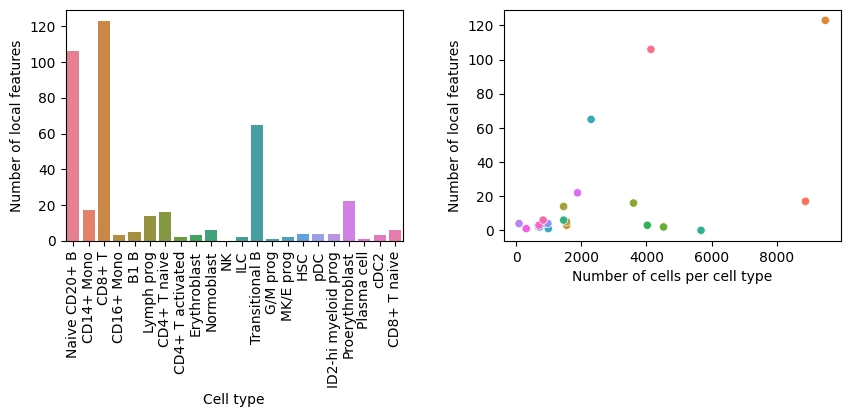

In [8]:
# plot a histogram of the number of unique features per cell type

# get the number of cells per cell type
cells_per_ct = data.obs['cell_type'].value_counts()
cells_per_ct = cells_per_ct[cell_types]
n_unique_features_per_ct = [len(unique_ct_features[ct]) for ct in cell_types]

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
# add spacing
fig.subplots_adjust(wspace=0.3)
sns.barplot(x=cell_types, y=n_unique_features_per_ct, ax=ax[0], hue=cell_types)
ax[0].set_xlabel('Cell type')
ax[0].set_ylabel('Number of local features')
# rotate the x-axis labels
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90, horizontalalignment='center')
sns.scatterplot(x=cells_per_ct, y=n_unique_features_per_ct, hue=cell_types, ax=ax[1])
ax[1].set_xlabel('Number of cells per cell type')
ax[1].set_ylabel('Number of local features')
ax[1].legend(title='Cell type', bbox_to_anchor=(1.05, 1), loc='upper left').set_visible(False)
plt.show()

In [8]:
go_df_feat_types = []
go_df_celltypes = []

for i in range(len(go_df)):
    feat = go_df['feature'][i]
    if feat in local_features:
        go_df_feat_types.append('local')
        # get which celltype it is unique to
        for ct in cell_types:
            if feat in unique_ct_features[ct]:
                go_df_celltypes.append(ct)
                break
    elif feat in global_features:
        go_df_feat_types.append('global')
        go_df_celltypes.append('')
    else:
        go_df_feat_types.append('')
        go_df_celltypes.append('')

go_df['feature_type'] = go_df_feat_types
go_df['celltype'] = go_df_celltypes

In [10]:
go_df.head()

n_hits    expected  binom_pval binom_direction  binom_fold_change  \
0     196  241.550815    0.002377               -           0.811423   
1     112  139.239818    0.018655               -           0.804368   
2      71   90.203187    0.043943               -           0.787112   
3      75   96.257092    0.027406               -           0.779163   
4     118  151.953019    0.004679               -           0.776556   

        fdr   z_score   mw_pval  effect_size       go_id  \
0  0.975895 -4.296093  0.000009     0.436968  GO:0006355   
1  0.986226 -2.448612  0.007170     0.452985  GO:0006468   
2  0.991268 -3.067987  0.001078     0.427036  GO:0009410   
3  0.990776 -3.928673  0.000043     0.409519  GO:0008380   
4  0.985488 -3.737072  0.000093     0.431259  GO:0043161   

                                             go_name  go_level  feature  \
0          regulation of DNA-templated transcription         8        0   
1                            protein phosphorylation         6        0   
2                    response to xenobiotic stimulus         3        0   
3                                       RNA splicing         5        0   
4  proteasome-mediated ubiquitin-dependent protei...         7        0   

   p_threshold  fold_change_threshold             go type feature_type  \
0      0.00001                    2.0  biological process       global   
1      0.00001                    2.0  biological process       global   
2      0.00001                    2.0  biological process       global   
3      0.00001                    2.0  biological process       global   
4      0.00001                    2.0  biological process       global   

  celltype  
0           
1           
2           
3           
4

In [9]:
# plot a density plot of mean vs max activations colored by global and local features
# get the mean and max activations
mean_activations = torch.mean(activations, dim=0).detach().cpu().numpy()
max_activations = torch.max(activations, dim=0)[0].detach().cpu().numpy()
nonzero_activations = torch.sum(activations != 0, dim=0).detach().cpu().numpy()
# get the feature types
feature_types = []
for i in range(activations.shape[1]):
    if i in local_features:
        feature_types.append('local')
    elif i in global_features:
        feature_types.append('global')
    else:
        feature_types.append('dead')

activ_df = pd.DataFrame({'mean': mean_activations, 'max': max_activations, 'feature type': feature_types, 'nonzero': nonzero_activations})
# sort by dead, global, local
activ_df['feature type'] = pd.Categorical(activ_df['feature type'], categories=['dead', 'global', 'local'], ordered=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


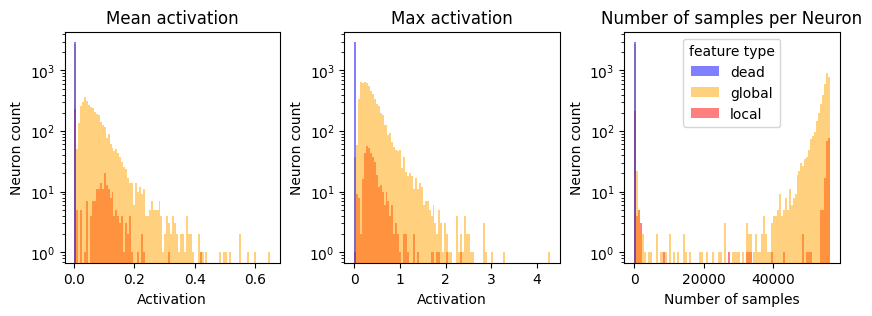

In [15]:
# make a plot with 2 histplots for mean and max
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
# add spacing
fig.subplots_adjust(wspace=0.3)
sns.histplot(activ_df, x='mean', ax=ax[0], bins=100, linewidth=0, hue='feature type', palette=['blue', 'orange', 'red'])
ax[0].set_yscale('log')
ax[0].set_xlabel('Activation')
ax[0].set_ylabel('Neuron count')
ax[0].set_title('Mean activation')
ax[0].legend().remove()
sns.histplot(activ_df, x='max', ax=ax[1], bins=100, linewidth=0, hue='feature type', palette=['blue', 'orange', 'red'])
ax[1].set_yscale('log')
ax[1].set_xlabel('Activation')
ax[1].set_ylabel('Neuron count')
ax[1].set_title('Max activation')
ax[1].legend().remove()
sns.histplot(activ_df, x='nonzero', ax=ax[2], bins=100, linewidth=0, hue='feature type', palette=['blue', 'orange', 'red'])
ax[2].set_yscale('log')
ax[2].set_xlabel('Number of samples')
ax[2].set_ylabel('Neuron count')
ax[2].set_title('Number of samples per Neuron')
plt.show()

In [15]:
min(activ_df[activ_df['feature type'] == 'local']['nonzero']), max(activ_df[activ_df['feature type'] == 'local']['nonzero'])

(5, 4297)

In [16]:
min(activ_df[activ_df['feature type'] == 'global']['nonzero']), max(activ_df[activ_df['feature type'] == 'global']['nonzero'])

(1, 56308)

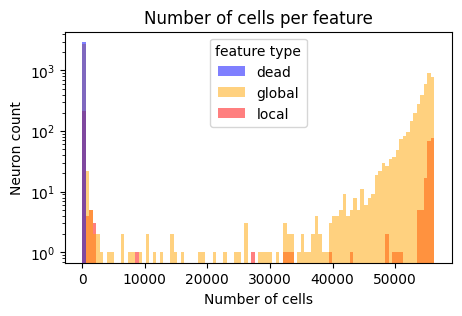

In [12]:
# plot the number of cells per feature

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
sns.histplot(activ_df, x='nonzero', ax=ax, bins=100, linewidth=0, hue='feature type', palette=['blue', 'orange', 'red'])
ax.set_yscale('log')
ax.set_xlabel('Number of cells')
ax.set_ylabel('Neuron count')
ax.set_title('Number of cells per feature')
plt.show()

### checks of left out features:

There seems to be no systematic bias in the left out features, at least not wrt to number of zeros or average activation (apart from the dead ones we left out).

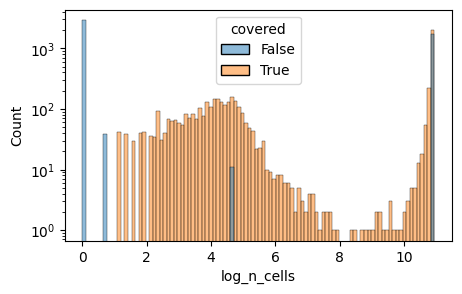

In [17]:
# plot a histogram of covered vs non covered features wrt the number of cells

n_zeros_per_feature = (activations == 0).sum(dim=0)
temp_df = pd.DataFrame({
    'n_cells': (activations.shape[0] - n_zeros_per_feature).numpy(),
    'covered': [x in go_df['feature'].unique() for x in range(activations.shape[1])]
})

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
# create logwise bins
temp_df['log_n_cells'] = np.log1p(temp_df['n_cells'])
sns.histplot(data=temp_df, x='log_n_cells', hue='covered', bins=100, ax=ax)
#sns.histplot(data=temp_df, x='n_cells', hue='covered', bins=100, ax=ax)
ax.set_yscale('log')
#ax.set_xscale('log')
plt.show()

### Unique GO terms

In [13]:
# count how often each unique go term appears in the b1b features
print(go_df['go_name'].value_counts())

cytoplasmic translation                  2892
translation                              2732
structural constituent of ribosome       2699
chromatin binding                        2628
mRNA splicing, via spliceosome           2196
                                         ... 
cellular response to interferon-alpha       2
glutamine metabolic process                 1
midbrain development                        1
adaptive thermogenesis                      1
response to UV-C                            1
Name: go_name, Length: 2596, dtype: int64


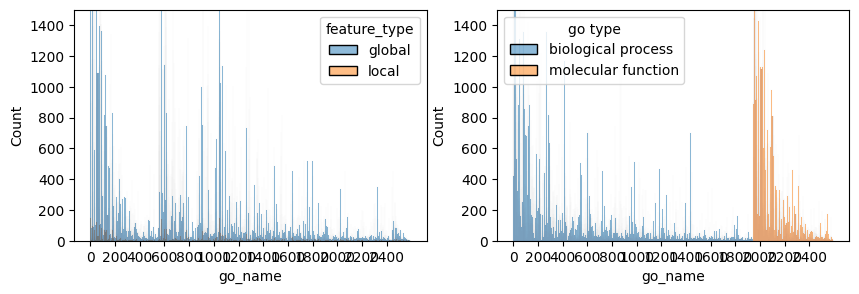

In [14]:
# make a histogram

# give every go term an index
go_ids = go_df['go_id'].unique()
go_id_dict = {go_ids[i]: i for i in range(len(go_ids))}
go_df['go_idx'] = go_df['go_id'].map(go_id_dict)
# make a dataframe with the idx and count
go_counts = go_df['go_idx'].value_counts().reset_index()

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
# add spacing
fig.subplots_adjust(wspace=0.2)
sns.histplot(data=go_df.sort_values('feature_type'), x='go_name', hue='feature_type', ax=ax[0], alpha=0.5)
ax[0].set_xticks(range(0, len(go_ids), 200))
ax[0].set_xticklabels(range(0, len(go_ids), 200))
ax[0].set_ylim(0, 1500)
sns.histplot(data=go_df, x='go_name', hue='go type', ax=ax[1])
# set the indices of go_idx as xticks (every 1000)
ax[1].set_ylim(0, 1500)
ax[1].set_xticks(range(0, len(go_ids), 200))
ax[1].set_xticklabels(range(0, len(go_ids), 200))
#plt.xticks([])
plt.show()

In [12]:
go_df

n_hits    expected  binom_pval binom_direction  binom_fold_change  \
0          196  241.550815    0.002377               -           0.811423   
1          112  139.239818    0.018655               -           0.804368   
2           71   90.203187    0.043943               -           0.787112   
3           75   96.257092    0.027406               -           0.779163   
4          118  151.953019    0.004679               -           0.776556   
...        ...         ...         ...             ...                ...   
422897      16    5.791453    0.000300               +           2.762692   
422898       6    2.242648    0.026525               +           2.675409   
422899      14    6.111831    0.005974               +           2.290639   
422900      15    7.689078    0.015327               +           1.950819   
422901      13    6.999032    0.032484               +           1.857400   

             fdr   z_score   mw_pval  effect_size       go_id  \
0       0.975895 -4.296093  0.000009     0.436968  GO:0006355   
1       0.986226 -2.448612  0.007170     0.452985  GO:0006468   
2       0.991268 -3.067987  0.001078     0.427036  GO:0009410   
3       0.990776 -3.928673  0.000043     0.409519  GO:0008380   
4       0.985488 -3.737072  0.000093     0.431259  GO:0043161   
...          ...       ...       ...          ...         ...   
422897  0.951662 -1.998941  0.022807     0.537977  GO:1990837   
422898  0.981873 -2.011342  0.022145     0.561076  GO:0051082   
422899  0.957704 -2.085792  0.018499     0.538594  GO:0044877   
422900  0.954683 -2.432907  0.007489     0.540233  GO:0005509   
422901  0.960725 -1.914968  0.027748     0.533156  GO:0004674   

                                                  go_name  go_level  feature  \
0               regulation of DNA-templated transcription         8        0   
1                                 protein phosphorylation         6        0   
2                         response to xenobiotic stimulus         3        0   
3                                            RNA splicing         5        0   
4       proteasome-mediated ubiquitin-dependent protei...         7        0   
...                                                   ...       ...      ...   
422897      sequence-specific double-stranded DNA binding         6     8191   
422898                           unfolded protein binding         3     8191   
422899                 protein-containing complex binding         2     8191   
422900                                calcium ion binding         6     8191   
422901           protein serine/threonine kinase activity         4     8191   

        p_threshold  fold_change_threshold             go type feature_type  \
0           0.00001                    2.0  biological process       global   
1           0.00001                    2.0  biological process       global   
2           0.00001                    2.0  biological process       global   
3           0.00001                    2.0  biological process       global   
4           0.00001                    2.0  biological process       global   
...             ...                    ...                 ...          ...   
422897      0.00001                    2.0  molecular function       global   
422898      0.00001                    2.0  molecular function       global   
422899      0.00001                    2.0  molecular function       global   
422900      0.00001                    2.0  molecular function       global   
422901      0.00001                    2.0  molecular function       global   

       celltype  
0                
1                
2                
3                
4                
...         ...  
422897           
422898           
422899           
422900           
422901           

[422902 rows x 18 columns]

In [10]:
# show me the go terms with 10 to 100 hits
go_value_counts = go_df['go_name'].value_counts()
go_df = go_df[(go_df['n_hits'] >= 1) & (go_df['mw_pval'] <= 0.01)]
go_df

n_hits    expected    binom_pval binom_direction  binom_fold_change  \
0          196  241.550815  2.376640e-03               -           0.811423   
1          112  139.239818  1.865545e-02               -           0.804368   
2           71   90.203187  4.394349e-02               -           0.787112   
3           75   96.257092  2.740576e-02               -           0.779163   
4          118  151.953019  4.678847e-03               -           0.776556   
...        ...         ...           ...             ...                ...   
422887       3    0.722210  3.659725e-02               +           4.153918   
422890      52    3.721316  3.877849e-42               +          13.973550   
422894       6    0.985779  5.346531e-04               +           6.086556   
422895       4    1.010424  1.944375e-02               +           3.958736   
422900      15    7.689078  1.532684e-02               +           1.950819   

             fdr   z_score   mw_pval  effect_size       go_id  \
0       0.975895 -4.296093  0.000009     0.436968  GO:0006355   
1       0.986226 -2.448612  0.007170     0.452985  GO:0006468   
2       0.991268 -3.067987  0.001078     0.427036  GO:0009410   
3       0.990776 -3.928673  0.000043     0.409519  GO:0008380   
4       0.985488 -3.737072  0.000093     0.431259  GO:0043161   
...          ...       ...       ...          ...         ...   
422887  0.984536 -2.896200  0.001889     0.618462  GO:0008233   
422890  0.842900 -4.246895  0.000011     0.600338  GO:0003735   
422894  0.981873 -3.510223  0.000224     0.660464  GO:0048306   
422895  0.987915 -2.582378  0.004906     0.383395  GO:0008137   
422900  0.954683 -2.432907  0.007489     0.540233  GO:0005509   

                                                  go_name  go_level  feature  \
0               regulation of DNA-templated transcription         8        0   
1                                 protein phosphorylation         6        0   
2                         response to xenobiotic stimulus         3        0   
3                                            RNA splicing         5        0   
4       proteasome-mediated ubiquitin-dependent protei...         7        0   
...                                                   ...       ...      ...   
422887                                 peptidase activity         3     8190   
422890                 structural constituent of ribosome         2     8191   
422894                  calcium-dependent protein binding         3     8191   
422895           NADH dehydrogenase (ubiquinone) activity         2     8191   
422900                                calcium ion binding         6     8191   

        p_threshold  fold_change_threshold             go type feature_type  \
0           0.00001                    2.0  biological process       global   
1           0.00001                    2.0  biological process       global   
2           0.00001                    2.0  biological process       global   
3           0.00001                    2.0  biological process       global   
4           0.00001                    2.0  biological process       global   
...             ...                    ...                 ...          ...   
422887      0.00001                    2.0  molecular function       global   
422890      0.00001                    2.0  molecular function       global   
422894      0.00001                    2.0  molecular function       global   
422895      0.00001                    2.0  molecular function       global   
422900      0.00001                    2.0  molecular function       global   

       celltype  
0                
1                
2                
3                
4                
...         ...  
422887           
422890           
422894           
422895           
422900           

[248977 rows x 18 columns]

### create GO parents

In [11]:
from goatools.obo_parser import GODag
obodag = GODag("01_data/go-basic.obo")

01_data/go-basic.obo: fmt(1.2) rel(2024-10-27) 44,017 Terms


In [12]:
# for each go term, create a list of all parents
go_terms = go_df['go_id'].unique()
print(len(go_terms))
go_terms_ancestry = {}

for go_term in go_terms:
    go_obj = obodag[go_term]
    level = go_obj.level
    out_parents = []
    out_levels = []
    while level > 1:
        parents = list(go_obj.parents)
        if len(parents) > 1:
            # get the parent with level-1
            for parent in parents:
                if parent.level == level - 1:
                    go_obj = parent
                    break
        else:
            go_obj = parents[0]
        out_parents.append(go_obj.id)
        out_levels.append(go_obj.level)
        level = go_obj.level
    go_terms_ancestry[go_term] = {'parents': out_parents, 'levels': out_levels}

2503


In [13]:
parent_go_ids = []

for go_term in go_terms_ancestry.keys():
    if len(go_terms_ancestry[go_term]['parents']) == 0:
        continue
    last_level = go_terms_ancestry[go_term]['levels'][-1]
    if last_level == 1:
        #print(go_terms_ancestry[go_term]['parents'])
        #print(go_terms_ancestry[go_term]['parents'][-1])
        parent_go_ids.append(go_terms_ancestry[go_term]['parents'][-1])

parent_go_ids = list(set(parent_go_ids))
print('There are {} parent go terms (level 1)'.format(len(parent_go_ids)))

There are 34 parent go terms (level 1)


In [14]:
go_df['parent_go_id_level1'] = go_df['go_id'].apply(lambda x: go_terms_ancestry[x]['parents'][-1] if len(go_terms_ancestry[x]['parents']) > 0 else x)
go_df['parent_go_name_level1'] = go_df['parent_go_id_level1'].apply(lambda x: obodag[x].name)
#go_df['parent_go_id_level2'] = go_df['go_id'].apply(lambda x: go_terms_ancestry[x]['parents'][-2] if len(go_terms_ancestry[x]['parents']) > 1 else x if len(go_terms_ancestry[x]['parents']) == 1 else '')
go_df['parent_go_id_level2'] = go_df['go_id'].apply(lambda x: go_terms_ancestry[x]['parents'][-2] if len(go_terms_ancestry[x]['parents']) > 1 else x)
go_df['parent_go_name_level2'] = go_df['parent_go_id_level2'].apply(lambda x: obodag[x].name if x != '' else '')
#go_df['parent_go_id_level3'] = go_df['go_id'].apply(lambda x: go_terms_ancestry[x]['parents'][-3] if len(go_terms_ancestry[x]['parents']) > 2 else x if len(go_terms_ancestry[x]['parents']) == 2 else '')
go_df['parent_go_id_level3'] = go_df['go_id'].apply(lambda x: go_terms_ancestry[x]['parents'][-3] if len(go_terms_ancestry[x]['parents']) > 2 else x)
go_df['parent_go_name_level3'] = go_df['parent_go_id_level3'].apply(lambda x: obodag[x].name if x != '' else '')
#go_df['parent_go_id_level4'] = go_df['go_id'].apply(lambda x: go_terms_ancestry[x]['parents'][-4] if len(go_terms_ancestry[x]['parents']) > 3 else x if len(go_terms_ancestry[x]['parents']) == 3 else '')
go_df['parent_go_id_level4'] = go_df['go_id'].apply(lambda x: go_terms_ancestry[x]['parents'][-4] if len(go_terms_ancestry[x]['parents']) > 3 else x)
go_df['parent_go_name_level4'] = go_df['parent_go_id_level4'].apply(lambda x: obodag[x].name if x != '' else '')

In [18]:
go_df

n_hits    expected    binom_pval binom_direction  binom_fold_change  \
0          196  241.550815  2.376640e-03               -           0.811423   
1          112  139.239818  1.865545e-02               -           0.804368   
2           71   90.203187  4.394349e-02               -           0.787112   
3           75   96.257092  2.740576e-02               -           0.779163   
4          118  151.953019  4.678847e-03               -           0.776556   
...        ...         ...           ...             ...                ...   
422887       3    0.722210  3.659725e-02               +           4.153918   
422890      52    3.721316  3.877849e-42               +          13.973550   
422894       6    0.985779  5.346531e-04               +           6.086556   
422895       4    1.010424  1.944375e-02               +           3.958736   
422900      15    7.689078  1.532684e-02               +           1.950819   

             fdr   z_score   mw_pval  effect_size       go_id  ...  \
0       0.975895 -4.296093  0.000009     0.436968  GO:0006355  ...   
1       0.986226 -2.448612  0.007170     0.452985  GO:0006468  ...   
2       0.991268 -3.067987  0.001078     0.427036  GO:0009410  ...   
3       0.990776 -3.928673  0.000043     0.409519  GO:0008380  ...   
4       0.985488 -3.737072  0.000093     0.431259  GO:0043161  ...   
...          ...       ...       ...          ...         ...  ...   
422887  0.984536 -2.896200  0.001889     0.618462  GO:0008233  ...   
422890  0.842900 -4.246895  0.000011     0.600338  GO:0003735  ...   
422894  0.981873 -3.510223  0.000224     0.660464  GO:0048306  ...   
422895  0.987915 -2.582378  0.004906     0.383395  GO:0008137  ...   
422900  0.954683 -2.432907  0.007489     0.540233  GO:0005509  ...   

       feature_type  celltype  parent_go_id_level1  \
0            global                     GO:0065007   
1            global                     GO:0009987   
2            global                     GO:0050896   
3            global                     GO:0009987   
4            global                     GO:0009987   
...             ...       ...                  ...   
422887       global                     GO:0003824   
422890       global                     GO:0005198   
422894       global                     GO:0005488   
422895       global                     GO:0009055   
422900       global                     GO:0005488   

               parent_go_name_level1  parent_go_id_level2  \
0              biological regulation           GO:0050789   
1                   cellular process           GO:0008152   
2               response to stimulus           GO:0042221   
3                   cellular process           GO:0008152   
4                   cellular process           GO:0008152   
...                              ...                  ...   
422887            catalytic activity           GO:0016787   
422890  structural molecule activity           GO:0003735   
422894                       binding           GO:0005515   
422895    electron transfer activity           GO:0008137   
422900                       binding           GO:0036094   

                           parent_go_name_level2 parent_go_id_level3  \
0               regulation of biological process          GO:0050794   
1                              metabolic process          GO:0006793   
2                           response to chemical          GO:0009410   
3                              metabolic process          GO:0044238   
4                              metabolic process          GO:0043170   
...                                          ...                 ...   
422887                        hydrolase activity          GO:0008233   
422890        structural constituent of ribosome          GO:0003735   
422894                           protein binding          GO:0048306   
422895  NADH dehydrogenase (ubiquinone) activity          GO:0008137   
422900                    small molecule bin

### create the GO-feature matrix

In [15]:
# create a matrix of all go terms and features

go_feature_matrix = torch.zeros((len(go_df['go_name'].unique()), activations.shape[1]))

for i, go_id in enumerate(go_df['go_id'].unique()):
    for feat in go_df[go_df['go_id'] == go_id]['feature']:
        go_feature_matrix[i,feat] = 1

# remove all columns with zero sum (unused features)
mtrx_go_ids = go_df['go_id'].unique()
mtrx_go_names = [obodag[x].name for x in mtrx_go_ids]
mtrx_feature_ids = torch.where(go_feature_matrix.sum(dim=0) > 0)[0]

go_feature_matrix = go_feature_matrix[:,torch.where(go_feature_matrix.sum(dim=0) > 0)[0]]

### UMAPs

/home/vschuste/miniconda3/envs/sc_mechinterp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/vschuste/miniconda3/envs/sc_mechinterp/lib/python3.9/site-packages/umap/umap_.py:1401: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/vschuste/miniconda3/envs/sc_mechinterp/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/vschuste/miniconda3/envs/sc_mechinterp/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


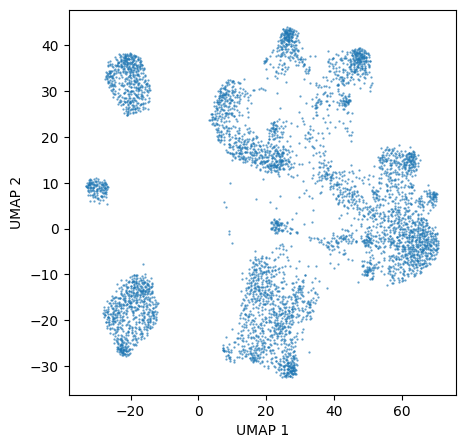

In [16]:
import umap

reducer = umap.UMAP(n_components=2, min_dist=1.0, n_neighbors=10, random_state=0, spread=10)
embedding = reducer.fit_transform(go_feature_matrix.T)

df_umap = pd.DataFrame(embedding, columns=['UMAP 1', 'UMAP 2'])
df_umap['feature'] = mtrx_feature_ids.numpy()

# plot the UMAP

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(data=df_umap, x='UMAP 1', y='UMAP 2', s=2, alpha=0.7, ec=None)
plt.show()

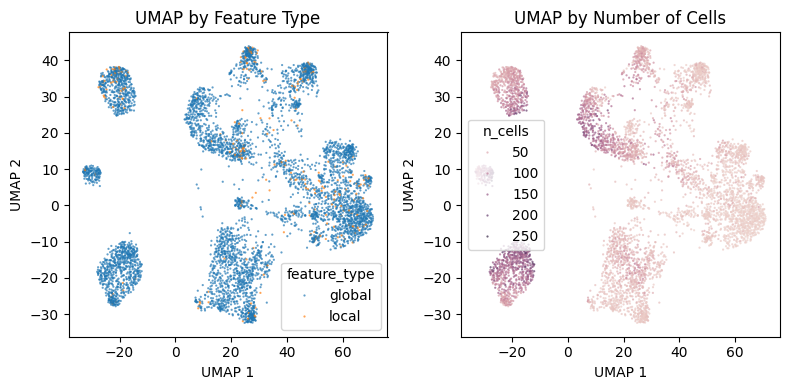

In [17]:
df_umap['feature_type'] = ['local' if x in local_features else 'global' for x in df_umap['feature']]
n_cells_per_feature = go_feature_matrix.sum(dim=0).numpy()
df_umap['n_cells'] = n_cells_per_feature

# plot by feature type
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
sns.scatterplot(data=df_umap, x='UMAP 1', y='UMAP 2', hue='feature_type', s=2, alpha=0.7, ec=None, ax=ax[0])
ax[0].set_title('UMAP by Feature Type')

# plot by number of cells
sns.scatterplot(data=df_umap, x='UMAP 1', y='UMAP 2', hue='n_cells', s=2, alpha=0.7, ec=None, ax=ax[1])
ax[1].set_title('UMAP by Number of Cells')

plt.tight_layout()
plt.show()

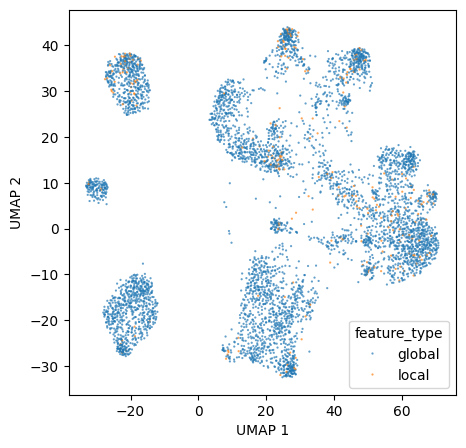

In [29]:
df_umap['feature_type'] = ['local' if x in local_features else 'global' for x in df_umap['feature']]

# plot by feature type
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(data=df_umap, x='UMAP 1', y='UMAP 2', hue='feature_type', s=2, alpha=0.7, ec=None)
plt.show()

/tmp/ipykernel_2227424/143637800.py:18: UserWarning: 
The palette list has fewer values (17) than needed (23) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data=df_umap, x='UMAP 1', y='UMAP 2', hue='level_1_go_term', s=2, alpha=1, ec=None, palette=level1_palette)


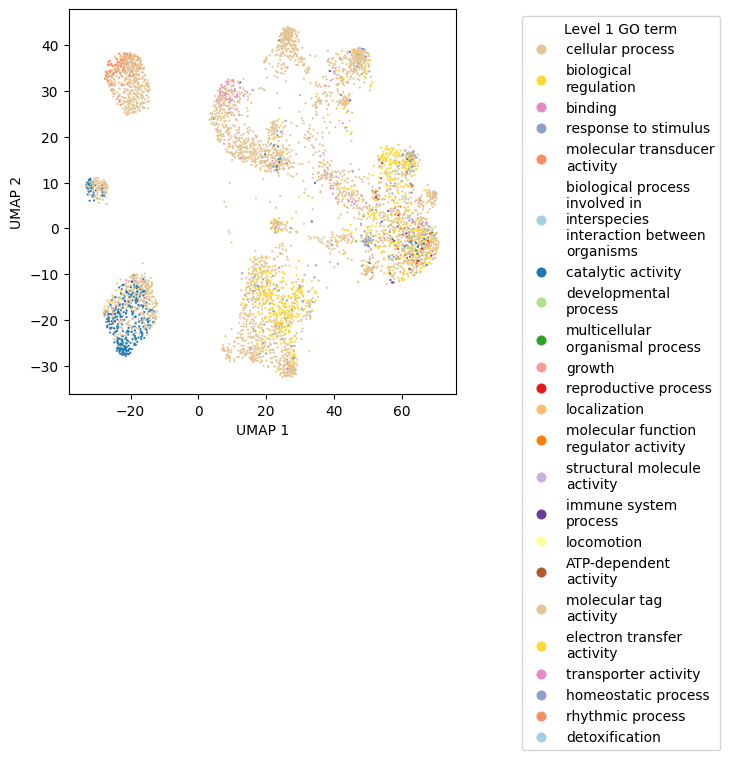

In [30]:
# color each feature by its most prevalent level 1 go term
level_1_mtrx_terms = []

for feat in mtrx_feature_ids:
    feat = feat.item()
    temp_go_term = go_df[go_df['feature'] == feat]['parent_go_name_level1'].value_counts().index[0]
    level_1_mtrx_terms.append(temp_go_term)

df_umap['level_1_go_term'] = level_1_mtrx_terms

level1_paletteb = sns.color_palette('Paired')
level1_palettea = sns.color_palette('Set2_r')
level1_palettea = level1_palettea[:2] + level1_palettea[3:]
level1_palette = level1_palettea + level1_paletteb
level1_palette = level1_palette[:len(df_umap['level_1_go_term'].unique())]

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(data=df_umap, x='UMAP 1', y='UMAP 2', hue='level_1_go_term', s=2, alpha=1, ec=None, palette=level1_palette)
# if a legend handle is longer than 20 characters, break it up
handles, labels = ax.get_legend_handles_labels()
import textwrap
new_labels = [textwrap.fill(label, 20) for label in labels]
# also make the legend markers larger by scaling
ax.legend(handles, new_labels, title='Level 1 GO term', loc='upper right', bbox_to_anchor=(1.7, 1), markerscale=5)
plt.show()

/tmp/ipykernel_251684/3342102244.py:29: UserWarning: 
The palette list has fewer values (18) than needed (27) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data=df_temp, x='UMAP 1', y='UMAP 2', hue=term_snippet, size='relevant', alpha=0.7, ec=None, ax=ax_list[-1], palette=temp_palette, sizes=(10, 1))


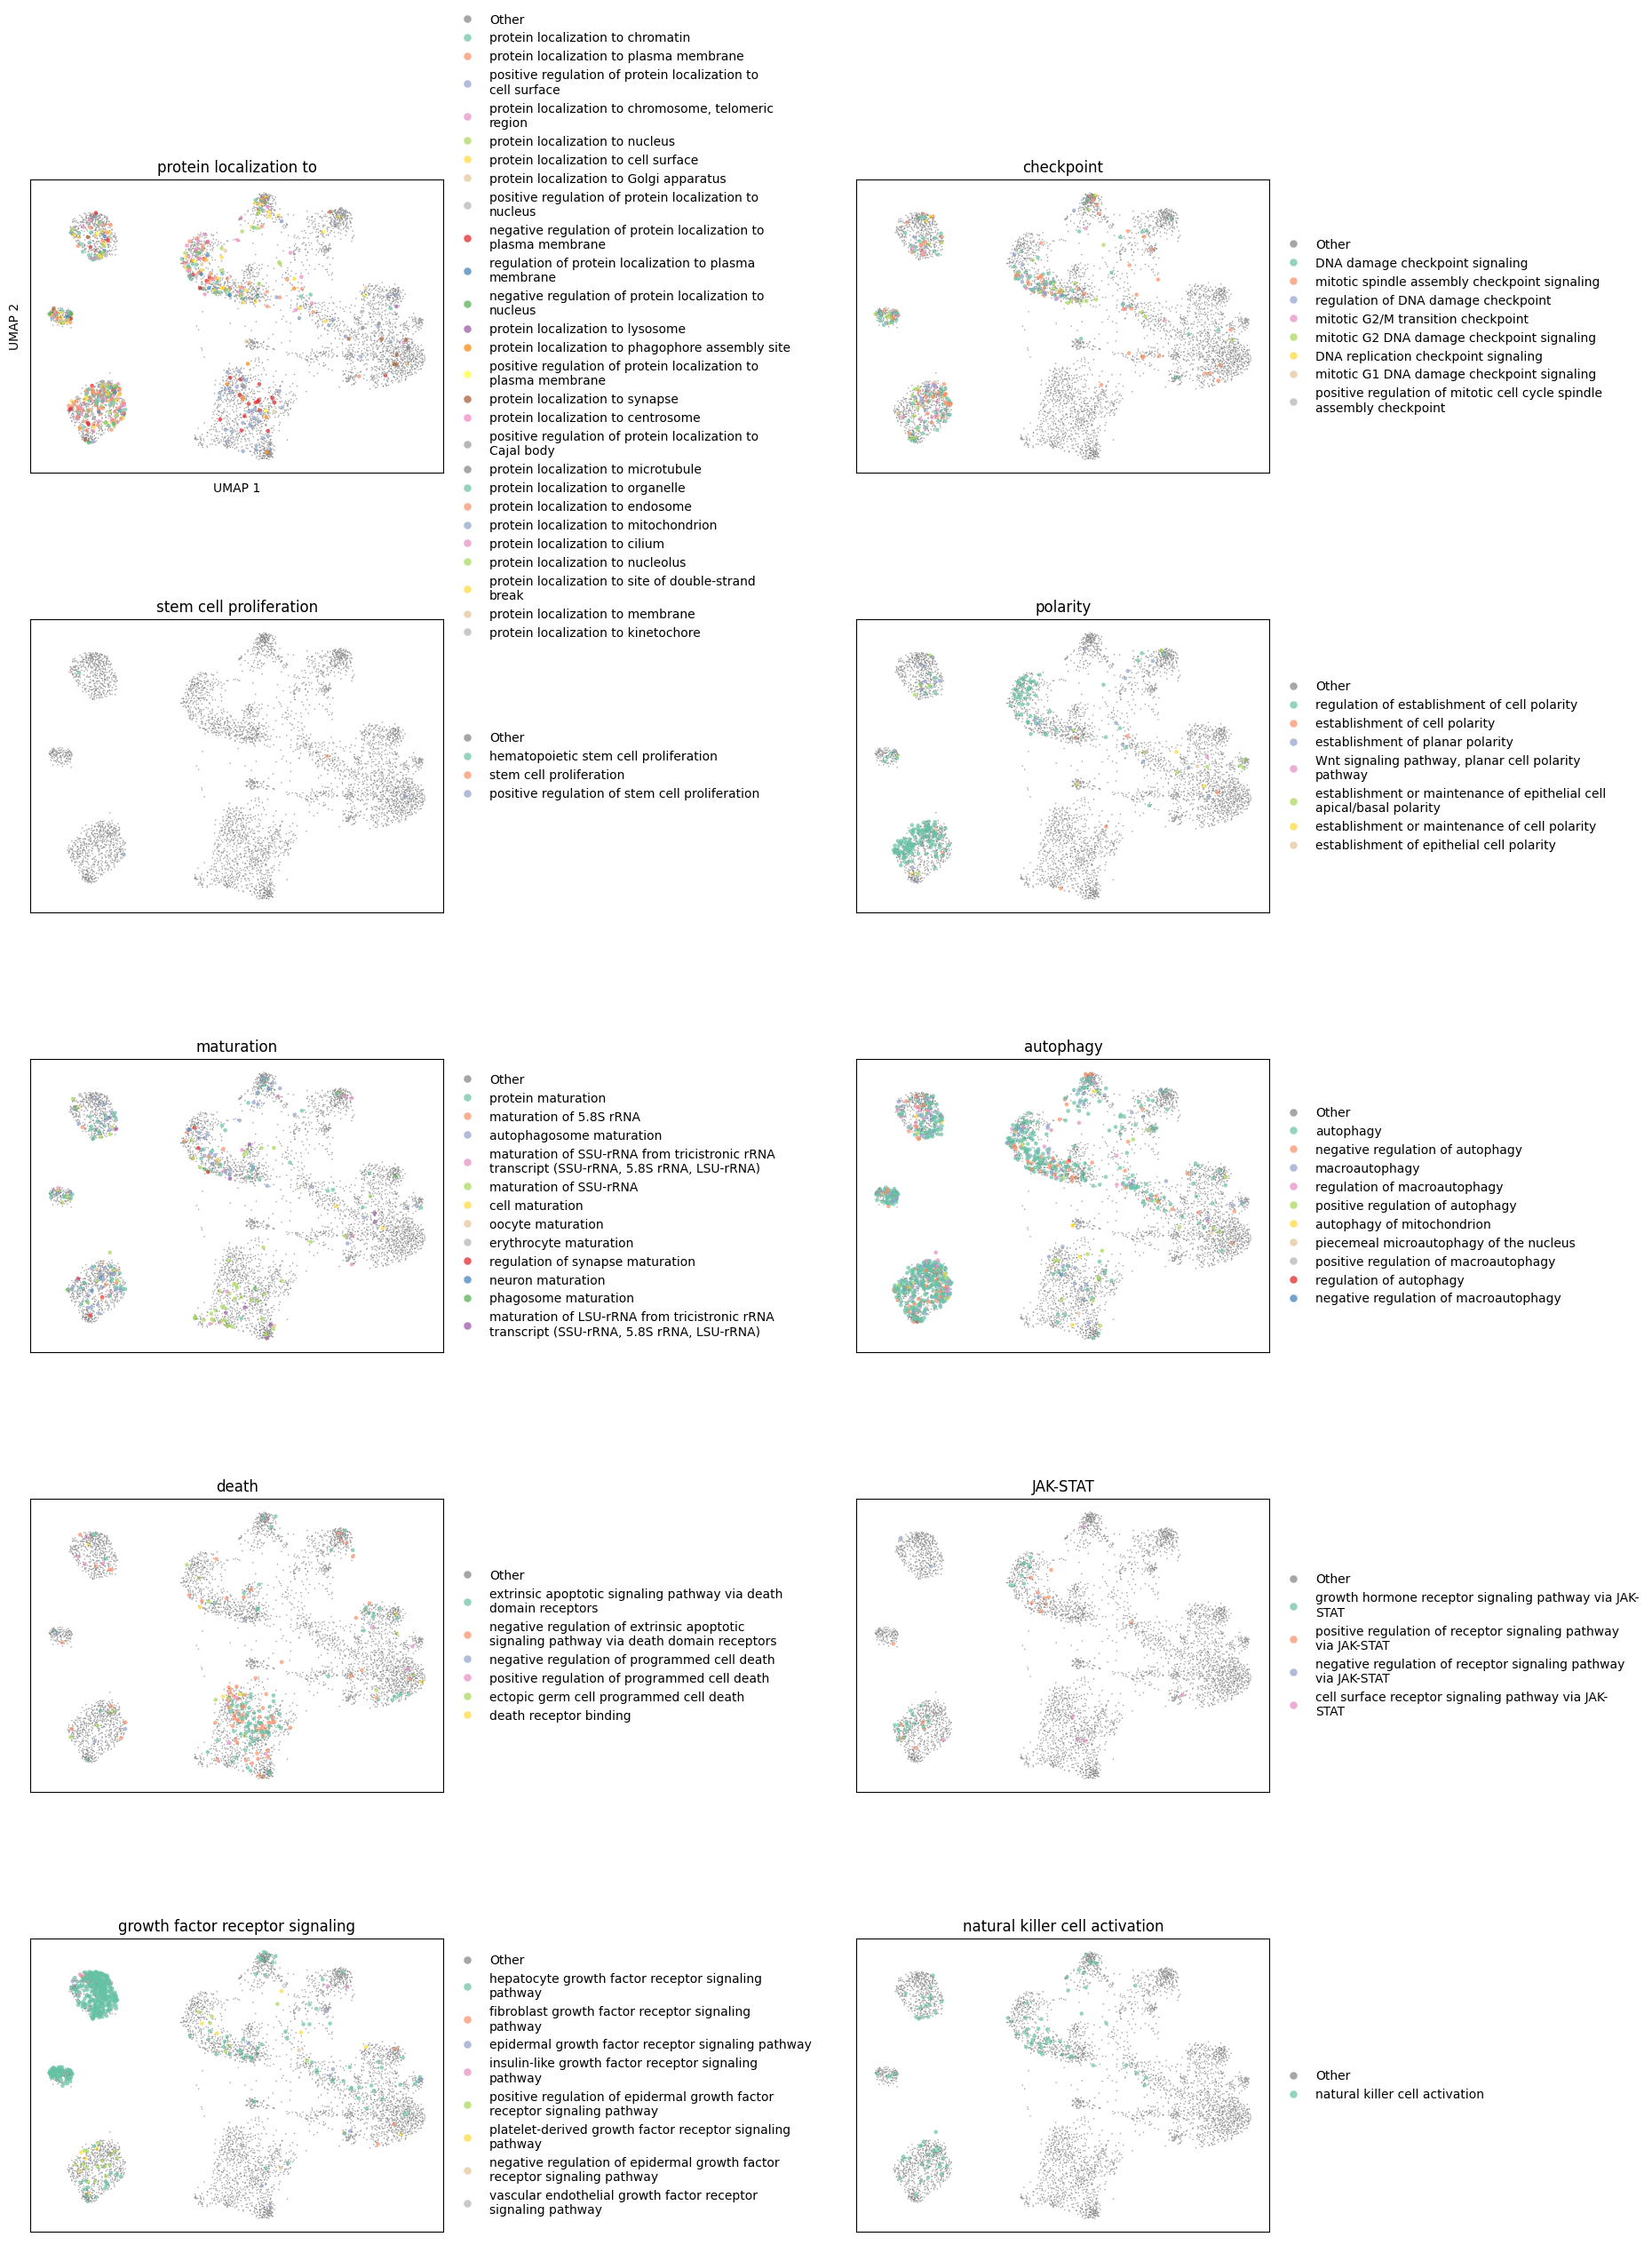

In [22]:
probing_snippets = ['protein localization to', 'checkpoint', 'stem cell proliferation', 'polarity', 'maturation', 'autophagy', 'death', 'JAK-STAT', 'growth factor receptor signaling', 'natural killer cell activation']

n_cols = 2
n_rows = 5

fig = plt.figure(figsize=(18, n_rows * 6))
import matplotlib.gridspec as gridspec
import textwrap
gs = gridspec.GridSpec(n_rows, n_cols, wspace=1.0, hspace=0.5)
ax_list = []

for i, term_snippet in enumerate(probing_snippets):
    ax_list.append(plt.subplot(gs[i//n_cols, i%n_cols]))
    test_go_terms = np.asarray([1 if term_snippet in x else 0 for x in mtrx_go_names]).astype(bool)
    unique_test_go_terms = [x for x in mtrx_go_names if term_snippet in x]
    test_counts = go_feature_matrix[test_go_terms,:].clone().sum(dim=0).int()
    # get the index of the max count
    max_index = go_feature_matrix[test_go_terms,:].clone().argmax(dim=0)
    test_counts = (test_counts > 0).float()
    df_temp = df_umap.copy()
    #df_temp[term_snippet] = test_counts.numpy()
    df_temp[term_snippet] = [unique_test_go_terms[x] if test_counts[i] == 1 else 'Other' for i, x in enumerate(max_index.numpy())]
    df_temp[term_snippet] = pd.Categorical(df_temp[term_snippet], categories=['Other'] + [x for x in unique_test_go_terms if x != 'Other'], ordered=True)
    # create a legend where the first color is grey and the rest is default
    temp_palette = [(0.5, 0.5, 0.5)] + sns.color_palette('Set2') + sns.color_palette('Set1')
    temp_palette = temp_palette[:len(df_temp[term_snippet].unique())]
    df_temp['relevant'] = test_counts.numpy()

    sns.scatterplot(data=df_temp, x='UMAP 1', y='UMAP 2', hue=term_snippet, size='relevant', alpha=0.7, ec=None, ax=ax_list[-1], palette=temp_palette, sizes=(10, 1))
    # move legend to the side
    handles, labels = ax_list[-1].get_legend_handles_labels()
    labels = [textwrap.fill(label, 50) for label in labels]
    ax_list[-1].legend(handles[1:-3], labels[1:-3], loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False, markerscale=1, fontsize=10)

    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    if i == 0:
        ax_list[-1].set_ylabel('UMAP 2')
        ax_list[-1].set_xlabel('UMAP 1')
    else:
        ax_list[-1].set_ylabel('')
        ax_list[-1].set_xlabel('')
    ax_list[-1].set_title(term_snippet)
    # remove the legend
    #ax_list[-1].legend().remove()

plt.savefig('03_results/figures/sc_supp_automatic_feature_analysis_probing_geneformer.png', bbox_inches='tight', dpi=300)
plt.show()

/tmp/ipykernel_2227424/2258405966.py:5: UserWarning: 
The palette list has fewer values (17) than needed (23) and will cycle, which may produce an uninterpretable plot.
  sns.histplot(data=df_umap, x='level_1_go_term', ax=ax, hue='level_1_go_term', palette=level1_palette, linewidth=0)
/tmp/ipykernel_2227424/2258405966.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticklabels, rotation=90, horizontalalignment='center')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


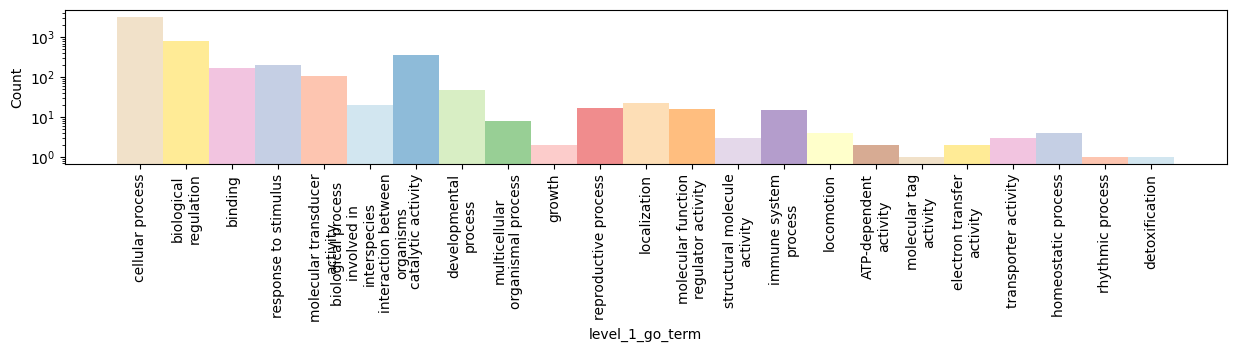

In [31]:
# plot a histogram of the first level go terms

fig, ax = plt.subplots(1, 1, figsize=(15, 2))
# add a gap between the bars
sns.histplot(data=df_umap, x='level_1_go_term', ax=ax, hue='level_1_go_term', palette=level1_palette, linewidth=0)
# rotate the x-axis labels
ticklabels = ax.get_xticklabels()
# wrap the labels
ticklabels = [textwrap.fill(label.get_text(), 20) for label in ticklabels]
ax.set_xticklabels(ticklabels, rotation=90, horizontalalignment='center')
# remove legend
ax.legend().remove()
# log scale
ax.set_yscale('log')
plt.show()

In [32]:
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'legend.fontsize': 'small'})

/tmp/ipykernel_2227424/2883922971.py:59: UserWarning: 
The palette list has fewer values (17) than needed (23) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data=df_umap, x='UMAP 1', y='UMAP 2', hue='level_1_go_term', s=3, alpha=1, ec=None, palette=level1_palette, ax=ax_list[2])


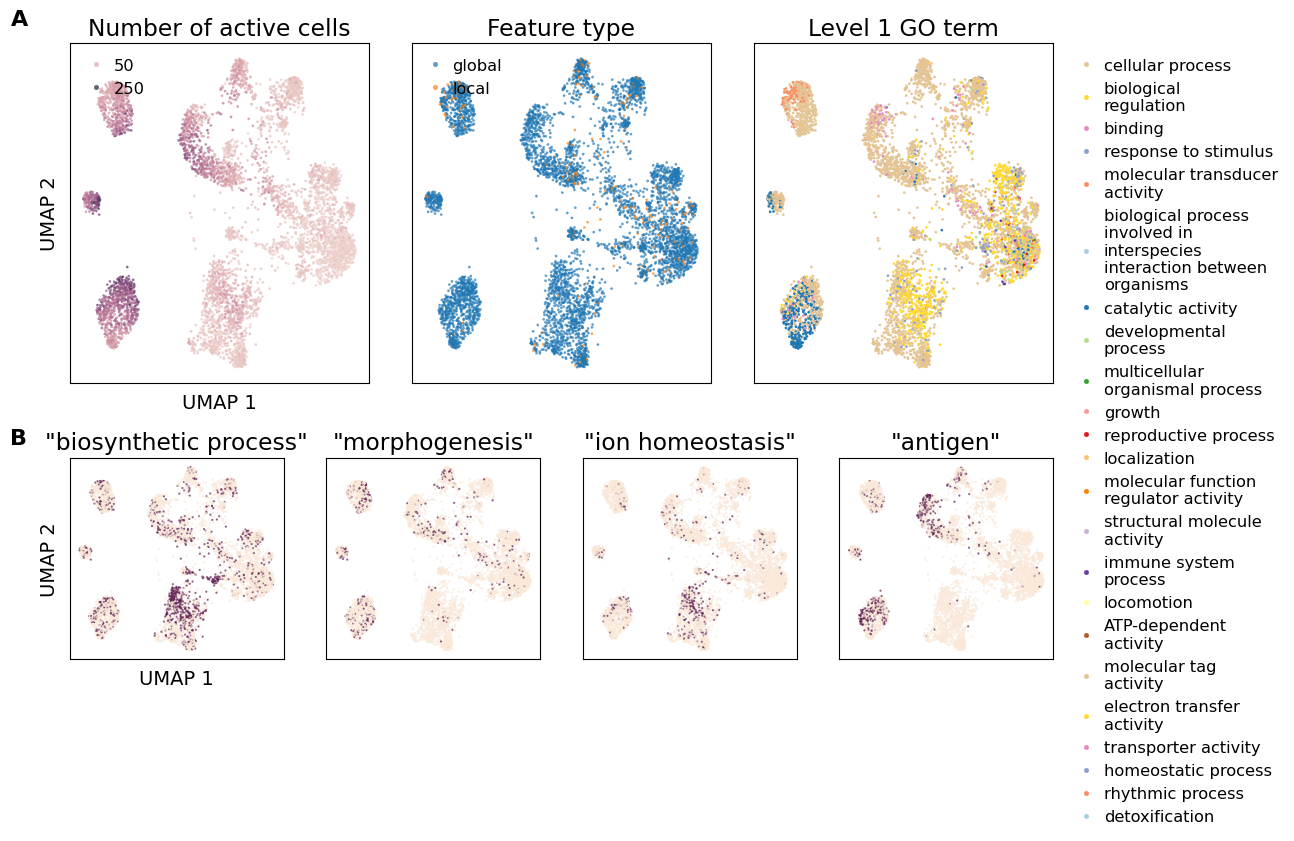

In [33]:
# create a nice grid plot with 6 columns and 4 rows

n_cols = 15
n_rows = 5

legend_x = 0.3
legend_y = 1
handletextpad = 0.1
markerscale = 2

fig = plt.figure(figsize=(16, 8))
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(n_rows, n_cols, wspace=1.0, hspace=1.2)
ax_list = []

# the first row are umaps and span over 2 rows
ax_list.append(plt.subplot(gs[0:3, 0:4]))
# add "A" on the grid
ax_list[0].text(-0.14, 1.1, 'A', transform=ax_list[0].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
# here color by number of cells
n_cells_per_feature = go_feature_matrix.sum(dim=0).numpy()
df_umap['n_cells'] = n_cells_per_feature
sns.scatterplot(data=df_umap, x='UMAP 1', y='UMAP 2', hue='n_cells', s=3, alpha=0.7, ec=None, ax=ax_list[0])
# remove all ticks
ax_list[0].set_xticks([])
ax_list[0].set_yticks([])
# move the legend outside
# keep only the first and last legend handles and labels
handles, labels = ax_list[0].get_legend_handles_labels()
handles = [handles[0], handles[-1]]
labels = [labels[0], labels[-1]]
ax_list[0].legend(handles, labels, loc='upper right', bbox_to_anchor=(legend_x, legend_y), frameon=False, handletextpad=handletextpad, markerscale=markerscale)
ax_list[0].set_title('Number of active cells')

# next plot a umap colored by feature type
ax_list.append(plt.subplot(gs[0:3, 4:8]))
sns.scatterplot(data=df_umap, x='UMAP 1', y='UMAP 2', hue='feature_type', s=3, alpha=0.7, ec=None, ax=ax_list[1])
ax_list[1].set_xticks([])
ax_list[1].set_yticks([])
ax_list[1].set_xlabel('')
ax_list[1].set_ylabel('')
ax_list[1].legend(loc='upper right', bbox_to_anchor=(legend_x+0.05, legend_y), frameon=False, handletextpad=handletextpad, markerscale=markerscale)
ax_list[1].set_title('Feature type')

# next plot a umap colored by level1 go term
ax_list.append(plt.subplot(gs[0:3, 8:12]))
# color each feature by its most prevalent level 1 go term
level_1_mtrx_terms = []
for feat in mtrx_feature_ids:
    feat = feat.item()
    temp_go_term = go_df[go_df['feature'] == feat]['parent_go_name_level1'].value_counts().index[0]
    level_1_mtrx_terms.append(temp_go_term)
df_umap['level_1_go_term'] = level_1_mtrx_terms
level1_paletteb = sns.color_palette('Paired')
level1_palettea = sns.color_palette('Set2_r')
level1_palettea = level1_palettea[:2] + level1_palettea[3:]
level1_palette = level1_palettea + level1_paletteb
level1_palette = level1_palette[:len(df_umap['level_1_go_term'].unique())]
sns.scatterplot(data=df_umap, x='UMAP 1', y='UMAP 2', hue='level_1_go_term', s=3, alpha=1, ec=None, palette=level1_palette, ax=ax_list[2])
ax_list[2].set_xticks([])
ax_list[2].set_yticks([])
ax_list[2].set_xlabel('')
ax_list[2].set_ylabel('')
ax_list[2].set_title('Level 1 GO term')
#ax_list[2].legend().remove()
# wrap the text for the legend
handles, labels = ax_list[2].get_legend_handles_labels()
labels = [textwrap.fill(label, 20) for label in labels]
ax_list[2].legend(handles, labels, loc='upper right', bbox_to_anchor=(1.8, legend_y), frameon=False, handletextpad=handletextpad, markerscale=markerscale, ncol=1)

binary_colors = sns.color_palette('rocket_r', 100)
binary_colors = [binary_colors[0], binary_colors[75]]

ax_list.append(plt.subplot(gs[3:5, 0:3]))
ax_list[-1].text(-0.2, 1.15, 'B', transform=ax_list[-1].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
term_snippet = 'biosynthetic process'
test_go_terms = np.asarray([1 if term_snippet in x else 0 for x in mtrx_go_names]).astype(bool)
test_counts = go_feature_matrix[test_go_terms,:].clone().sum(dim=0).int()
test_counts = (test_counts > 0).float()
df_temp = df_umap.copy()
df_temp[term_snippet] = test_counts.numpy()
sns.scatterplot(data=df_temp, x='UMAP 1', y='UMAP 2', hue=term_snippet, s=2, alpha=0.7, ec=None, palette=binary_colors, ax=ax_list[-1])
ax_list[-1].set_xticks([])
ax_list[-1].set_yticks([])
ax_list[-1].set_title('"{}"'.format(term_snippet))
# remove the legend
ax_list[-1].legend().remove()

ax_list.append(plt.subplot(gs[3:5, 3:6]))
term_snippet = 'morphogenesis'
test_go_terms = np.asarray([1 if term_snippet in x else 0 for x in mtrx_go_names]).astype(bool)
test_counts = go_feature_matrix[test_go_terms,:].clone().sum(dim=0).int()
test_counts = (test_counts > 0).float()
df_temp = df_umap.copy()
df_temp[term_snippet] = test_counts.numpy()
sns.scatterplot(data=df_temp, x='UMAP 1', y='UMAP 2', hue=term_snippet, s=2, alpha=0.7, ec=None, palette=binary_colors, ax=ax_list[-1])
ax_list[-1].set_xticks([])
ax_list[-1].set_yticks([])
ax_list[-1].set_xlabel('')
ax_list[-1].set_ylabel('')
ax_list[-1].set_title('"{}"'.format(term_snippet))
# remove the legend
ax_list[-1].legend().remove()

ax_list.append(plt.subplot(gs[3:5, 6:9]))
term_snippet = 'ion homeostasis'
test_go_terms = np.asarray([1 if term_snippet in x else 0 for x in mtrx_go_names]).astype(bool)
test_counts = go_feature_matrix[test_go_terms,:].clone().sum(dim=0).int()
test_counts = (test_counts > 0).float()
df_temp = df_umap.copy()
df_temp[term_snippet] = test_counts.numpy()
sns.scatterplot(data=df_temp, x='UMAP 1', y='UMAP 2', hue=term_snippet, s=2, alpha=0.7, ec=None, palette=binary_colors, ax=ax_list[-1])
ax_list[-1].set_xticks([])
ax_list[-1].set_yticks([])
ax_list[-1].set_xlabel('')
ax_list[-1].set_ylabel('')
ax_list[-1].set_title('"{}"'.format(term_snippet))
# remove the legend
ax_list[-1].legend().remove()

ax_list.append(plt.subplot(gs[3:5, 9:12]))
term_snippet = 'antigen'
test_go_terms = np.asarray([1 if term_snippet in x else 0 for x in mtrx_go_names]).astype(bool)
test_counts = go_feature_matrix[test_go_terms,:].clone().sum(dim=0).int()
test_counts = (test_counts > 0).float()
df_temp = df_umap.copy()
df_temp[term_snippet] = test_counts.numpy()
sns.scatterplot(data=df_temp, x='UMAP 1', y='UMAP 2', hue=term_snippet, s=2, alpha=0.7, ec=None, palette=binary_colors, ax=ax_list[-1])
ax_list[-1].set_xticks([])
ax_list[-1].set_yticks([])
ax_list[-1].set_xlabel('')
ax_list[-1].set_ylabel('')
ax_list[-1].set_title('"{}"'.format(term_snippet))
# remove the legend
ax_list[-1].legend().remove()

# save as a pdf
#plt.savefig('03_results/figures/sc_automatic_feature_analysis_2.pdf', bbox_inches='tight')
plt.show()

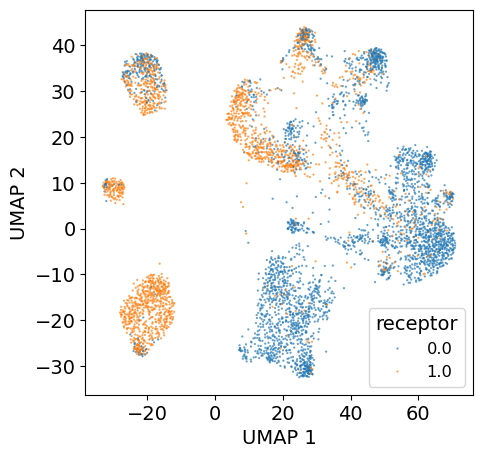

In [34]:
# what about receptors

receptor_go_terms = [1 if 'receptor' in x else 0 for x in mtrx_go_names]
receptor_counts = go_feature_matrix[receptor_go_terms,:].sum(dim=0)
# binarize
receptor_counts = (receptor_counts > 0).float()
df_umap['receptor'] = receptor_counts.numpy()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(data=df_umap, x='UMAP 1', y='UMAP 2', hue='receptor', s=2, alpha=0.7, ec=None, ax=ax)
plt.show()

Found 29 GO terms with 'protein localization' in their name


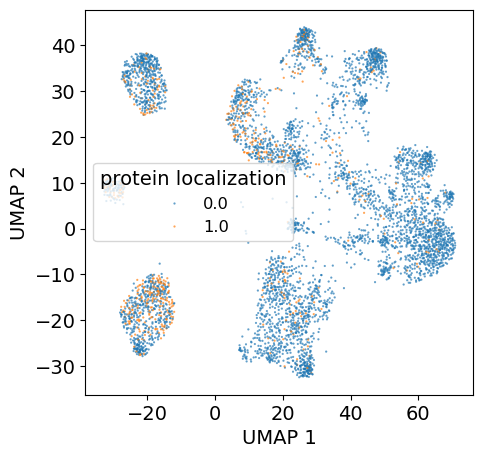

In [35]:
# what about receptors

term_snippet = 'protein localization'

test_go_terms = np.asarray([1 if term_snippet in x else 0 for x in mtrx_go_names]).astype(bool)
#print([mtrx_go_names[i] for i, x in enumerate(test_go_terms) if x == 1])
print(f"Found {sum(test_go_terms)} GO terms with '{term_snippet}' in their name")
test_counts = go_feature_matrix[test_go_terms,:].clone().sum(dim=0).int()
#test_counts = go_feature_matrix[:,:].clone().sum(dim=0).int()
test_counts = (test_counts > 0).float()
df_temp = df_umap.copy()
df_temp[term_snippet] = test_counts.numpy()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(data=df_temp, x='UMAP 1', y='UMAP 2', hue=term_snippet, s=2, alpha=0.7, ec=None, ax=ax)
plt.show()

Found 26 GO terms with 'protein localization to' in their name
Unique GO terms: ['protein localization to chromatin', 'protein localization to plasma membrane', 'positive regulation of protein localization to cell surface', 'protein localization to chromosome, telomeric region', 'protein localization to nucleus', 'protein localization to cell surface', 'protein localization to Golgi apparatus', 'positive regulation of protein localization to nucleus', 'negative regulation of protein localization to plasma membrane', 'regulation of protein localization to plasma membrane', 'negative regulation of protein localization to nucleus', 'protein localization to lysosome', 'protein localization to phagophore assembly site', 'positive regulation of protein localization to plasma membrane', 'protein localization to synapse', 'protein localization to centrosome', 'positive regulation of protein localization to Cajal body', 'protein localization to microtubule', 'protein localization to organelle',

/tmp/ipykernel_2227424/814831909.py:22: UserWarning: 
The palette list has fewer values (25) than needed (27) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data=df_temp, x='UMAP 1', y='UMAP 2', hue=term_snippet, size='relevant', alpha=0.7, ec=None, ax=ax, palette=temp_palette, sizes=(10, 1))


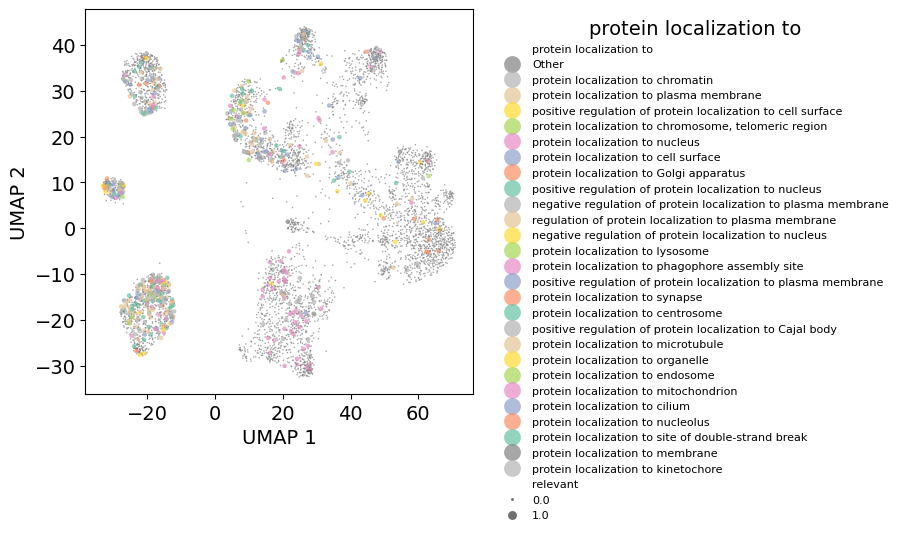

In [36]:
term_snippet = 'protein localization to'

test_go_terms = np.asarray([1 if term_snippet in x else 0 for x in mtrx_go_names]).astype(bool)
unique_test_go_terms = [x for x in mtrx_go_names if term_snippet in x]
print(f"Found {sum(test_go_terms)} GO terms with '{term_snippet}' in their name")
print(f"Unique GO terms: {unique_test_go_terms}")
test_counts = go_feature_matrix[test_go_terms,:].clone().sum(dim=0).int()
# get the index of the max count
max_index = go_feature_matrix[test_go_terms,:].clone().argmax(dim=0)
test_counts = (test_counts > 0).float()
df_temp = df_umap.copy()
#df_temp[term_snippet] = test_counts.numpy()
df_temp[term_snippet] = [unique_test_go_terms[x] if test_counts[i] == 1 else 'Other' for i, x in enumerate(max_index.numpy())]
df_temp[term_snippet] = pd.Categorical(df_temp[term_snippet], categories=['Other'] + [x for x in unique_test_go_terms if x != 'Other'], ordered=True)
# create a legend where the first color is grey and the rest is default
temp_palette = sns.color_palette('Set2', n_colors=len(df_temp[term_snippet].unique())-1)
temp_palette.append((0.5, 0.5, 0.5))  # add grey for 'Other'
temp_palette = temp_palette[::-1]  # reverse the order to have 'Other' last
df_temp['relevant'] = test_counts.numpy()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(data=df_temp, x='UMAP 1', y='UMAP 2', hue=term_snippet, size='relevant', alpha=0.7, ec=None, ax=ax, palette=temp_palette, sizes=(10, 1))
# move legend to the side
ax.legend(title=term_snippet, loc='upper right', bbox_to_anchor=(2.1, 1), frameon=False, markerscale=2, fontsize=8)
plt.show()

Found 8 GO terms with 'checkpoint' in their name
Unique GO terms: ['DNA damage checkpoint signaling', 'mitotic spindle assembly checkpoint signaling', 'regulation of DNA damage checkpoint', 'mitotic G2/M transition checkpoint', 'mitotic G2 DNA damage checkpoint signaling', 'DNA replication checkpoint signaling', 'mitotic G1 DNA damage checkpoint signaling', 'positive regulation of mitotic cell cycle spindle assembly checkpoint']


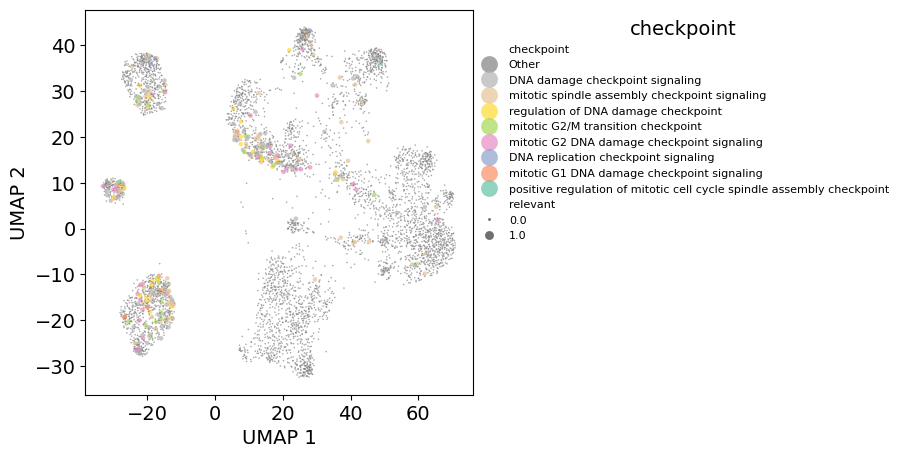

In [37]:
term_snippet = 'checkpoint'

test_go_terms = np.asarray([1 if term_snippet in x else 0 for x in mtrx_go_names]).astype(bool)
unique_test_go_terms = [x for x in mtrx_go_names if term_snippet in x]
print(f"Found {sum(test_go_terms)} GO terms with '{term_snippet}' in their name")
print(f"Unique GO terms: {unique_test_go_terms}")
test_counts = go_feature_matrix[test_go_terms,:].clone().sum(dim=0).int()
# get the index of the max count
max_index = go_feature_matrix[test_go_terms,:].clone().argmax(dim=0)
test_counts = (test_counts > 0).float()
df_temp = df_umap.copy()
#df_temp[term_snippet] = test_counts.numpy()
df_temp[term_snippet] = [unique_test_go_terms[x] if test_counts[i] == 1 else 'Other' for i, x in enumerate(max_index.numpy())]
df_temp[term_snippet] = pd.Categorical(df_temp[term_snippet], categories=['Other'] + [x for x in unique_test_go_terms if x != 'Other'], ordered=True)
# create a legend where the first color is grey and the rest is default
temp_palette = sns.color_palette('Set2', n_colors=len(df_temp[term_snippet].unique())-1)
temp_palette.append((0.5, 0.5, 0.5))  # add grey for 'Other'
temp_palette = temp_palette[::-1]  # reverse the order to have 'Other' last
df_temp['relevant'] = test_counts.numpy()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(data=df_temp, x='UMAP 1', y='UMAP 2', hue=term_snippet, size='relevant', alpha=0.7, ec=None, ax=ax, palette=temp_palette, sizes=(10, 1))
# move legend to the side
ax.legend(title=term_snippet, loc='upper right', bbox_to_anchor=(2.1, 1), frameon=False, markerscale=2, fontsize=8)
plt.show()

Found 16 GO terms with 'viral' in their name
Unique GO terms: ['positive regulation of viral genome replication', 'negative regulation of viral genome replication', 'IRES-dependent viral translational initiation', 'viral protein processing', 'positive regulation by host of viral transcription', 'negative regulation of viral transcription', 'positive regulation by host of viral genome replication', 'negative regulation of viral entry into host cell', 'viral budding via host ESCRT complex', 'viral budding from plasma membrane', 'antiviral innate immune response', 'negative regulation by host of viral transcription', 'viral release from host cell', 'suppression of viral release by host', 'positive regulation by host of viral process', 'positive regulation of viral entry into host cell']


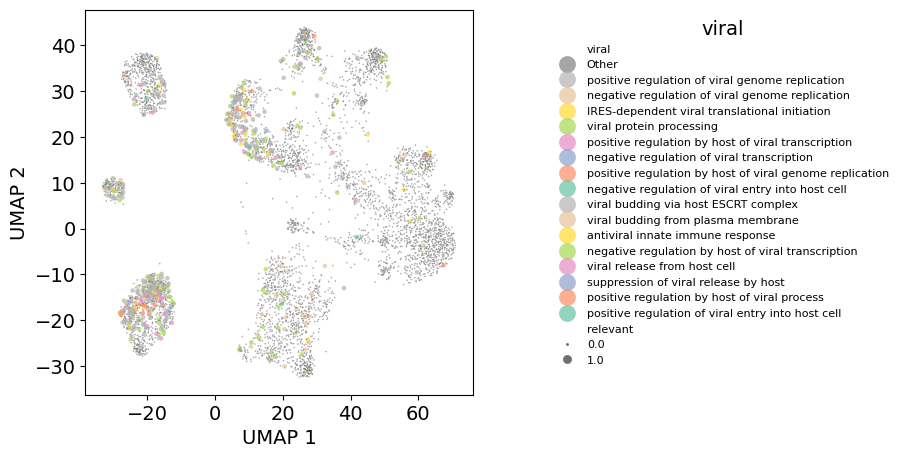

In [38]:
term_snippet = 'viral'

test_go_terms = np.asarray([1 if term_snippet in x else 0 for x in mtrx_go_names]).astype(bool)
unique_test_go_terms = [x for x in mtrx_go_names if term_snippet in x]
print(f"Found {sum(test_go_terms)} GO terms with '{term_snippet}' in their name")
print(f"Unique GO terms: {unique_test_go_terms}")
test_counts = go_feature_matrix[test_go_terms,:].clone().sum(dim=0).int()
# get the index of the max count
max_index = go_feature_matrix[test_go_terms,:].clone().argmax(dim=0)
test_counts = (test_counts > 0).float()
df_temp = df_umap.copy()
#df_temp[term_snippet] = test_counts.numpy()
df_temp[term_snippet] = [unique_test_go_terms[x] if test_counts[i] == 1 else 'Other' for i, x in enumerate(max_index.numpy())]
# set the order to 'Other' first
df_temp[term_snippet] = pd.Categorical(df_temp[term_snippet], categories=['Other'] + [x for x in unique_test_go_terms if x != 'Other'], ordered=True)
# create a legend where the first color is grey and the rest is default
temp_palette = sns.color_palette('Set2', n_colors=len(df_temp[term_snippet].unique())-1)
temp_palette.append((0.5, 0.5, 0.5))  # add grey for 'Other'
temp_palette = temp_palette[::-1]  # reverse the order to have 'Other' last
df_temp['relevant'] = test_counts.numpy()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(data=df_temp, x='UMAP 1', y='UMAP 2', hue=term_snippet, size='relevant', alpha=0.7, ec=None, ax=ax, palette=temp_palette, sizes=(10, 1))
# move legend to the side
ax.legend(title=term_snippet, loc='upper right', bbox_to_anchor=(2.1, 1), frameon=False, markerscale=2, fontsize=8)
plt.show()

Found 4 GO terms with 'chemokine' in their name
Unique GO terms: ['chemokine-mediated signaling pathway', 'cellular response to chemokine', 'positive regulation of chemokine production', 'chemokine activity']


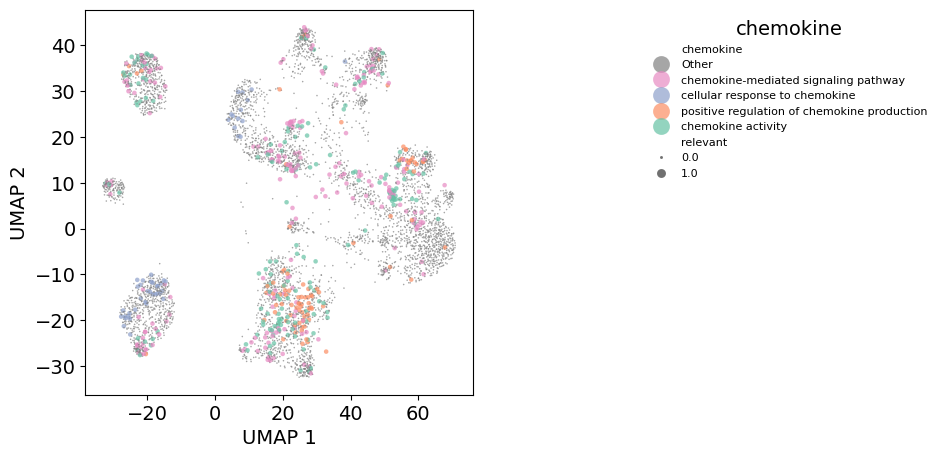

In [41]:
term_snippet = 'chemokine'

test_go_terms = np.asarray([1 if term_snippet in x else 0 for x in mtrx_go_names]).astype(bool)
unique_test_go_terms = [x for x in mtrx_go_names if term_snippet in x]
print(f"Found {sum(test_go_terms)} GO terms with '{term_snippet}' in their name")
print(f"Unique GO terms: {unique_test_go_terms}")
test_counts = go_feature_matrix[test_go_terms,:].clone().sum(dim=0).int()
# get the index of the max count
max_index = go_feature_matrix[test_go_terms,:].clone().argmax(dim=0)
test_counts = (test_counts > 0).float()
df_temp = df_umap.copy()
#df_temp[term_snippet] = test_counts.numpy()
df_temp[term_snippet] = [unique_test_go_terms[x] if test_counts[i] == 1 else 'Other' for i, x in enumerate(max_index.numpy())]
df_temp[term_snippet] = pd.Categorical(df_temp[term_snippet], categories=['Other'] + [x for x in unique_test_go_terms if x != 'Other'], ordered=True)
# create a legend where the first color is grey and the rest is default
temp_palette = sns.color_palette('Set2', n_colors=len(df_temp[term_snippet].unique())-1)
temp_palette.append((0.5, 0.5, 0.5))  # add grey for 'Other'
temp_palette = temp_palette[::-1]  # reverse the order to have 'Other' last
df_temp['relevant'] = test_counts.numpy()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(data=df_temp, x='UMAP 1', y='UMAP 2', hue=term_snippet, size='relevant', alpha=0.7, ec=None, ax=ax, palette=temp_palette, sizes=(10, 1))
# move legend to the side
ax.legend(title=term_snippet, loc='upper right', bbox_to_anchor=(2.2, 1), frameon=False, markerscale=2, fontsize=8)
plt.show()

Found 3 GO terms with 'stem cell proliferation' in their name
Unique GO terms: ['hematopoietic stem cell proliferation', 'stem cell proliferation', 'positive regulation of stem cell proliferation']


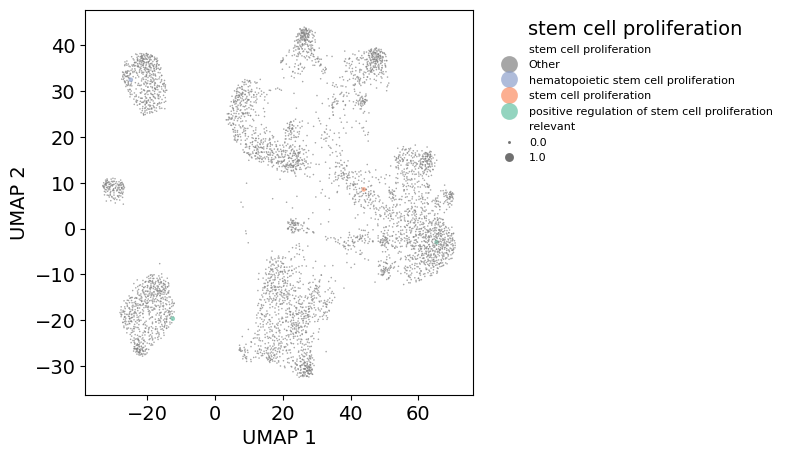

In [42]:
term_snippet = 'stem cell proliferation'

test_go_terms = np.asarray([1 if term_snippet in x else 0 for x in mtrx_go_names]).astype(bool)
unique_test_go_terms = [x for x in mtrx_go_names if term_snippet in x]
print(f"Found {sum(test_go_terms)} GO terms with '{term_snippet}' in their name")
print(f"Unique GO terms: {unique_test_go_terms}")
test_counts = go_feature_matrix[test_go_terms,:].clone().sum(dim=0).int()
# get the index of the max count
max_index = go_feature_matrix[test_go_terms,:].clone().argmax(dim=0)
test_counts = (test_counts > 0).float()
df_temp = df_umap.copy()
#df_temp[term_snippet] = test_counts.numpy()
df_temp[term_snippet] = [unique_test_go_terms[x] if test_counts[i] == 1 else 'Other' for i, x in enumerate(max_index.numpy())]
df_temp[term_snippet] = pd.Categorical(df_temp[term_snippet], categories=['Other'] + [x for x in unique_test_go_terms if x != 'Other'], ordered=True)
# create a legend where the first color is grey and the rest is default
temp_palette = sns.color_palette('Set2', n_colors=len(df_temp[term_snippet].unique())-1)
temp_palette.append((0.5, 0.5, 0.5))  # add grey for 'Other'
temp_palette = temp_palette[::-1]  # reverse the order to have 'Other' last
df_temp['relevant'] = test_counts.numpy()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(data=df_temp, x='UMAP 1', y='UMAP 2', hue=term_snippet, size='relevant', alpha=0.7, ec=None, ax=ax, palette=temp_palette, sizes=(10, 1))
# move legend to the side
ax.legend(title=term_snippet, loc='upper right', bbox_to_anchor=(1.8, 1), frameon=False, markerscale=2, fontsize=8)
plt.show()

Found 4 GO terms with 'JAK-STAT' in their name
Unique GO terms: ['growth hormone receptor signaling pathway via JAK-STAT', 'positive regulation of receptor signaling pathway via JAK-STAT', 'negative regulation of receptor signaling pathway via JAK-STAT', 'cell surface receptor signaling pathway via JAK-STAT']


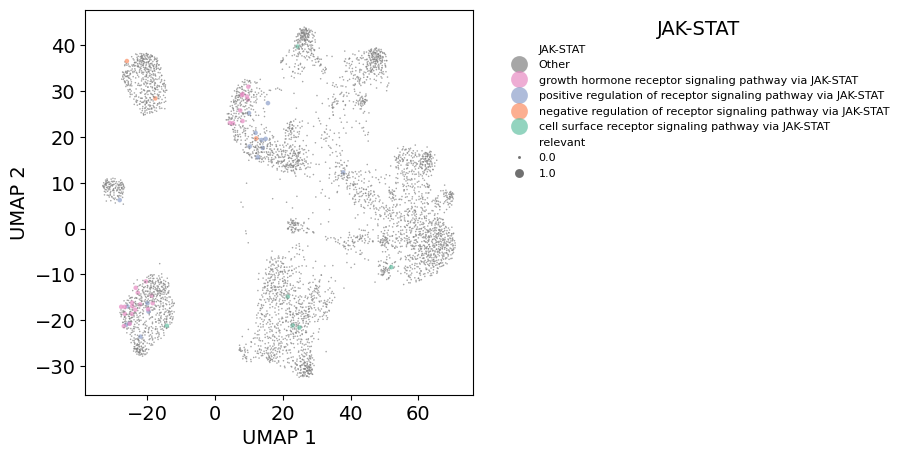

In [43]:
term_snippet = 'JAK-STAT'

test_go_terms = np.asarray([1 if term_snippet in x else 0 for x in mtrx_go_names]).astype(bool)
unique_test_go_terms = [x for x in mtrx_go_names if term_snippet in x]
print(f"Found {sum(test_go_terms)} GO terms with '{term_snippet}' in their name")
print(f"Unique GO terms: {unique_test_go_terms}")
test_counts = go_feature_matrix[test_go_terms,:].clone().sum(dim=0).int()
# get the index of the max count
max_index = go_feature_matrix[test_go_terms,:].clone().argmax(dim=0)
test_counts = (test_counts > 0).float()
df_temp = df_umap.copy()
#df_temp[term_snippet] = test_counts.numpy()
df_temp[term_snippet] = [unique_test_go_terms[x] if test_counts[i] == 1 else 'Other' for i, x in enumerate(max_index.numpy())]
df_temp[term_snippet] = pd.Categorical(df_temp[term_snippet], categories=['Other'] + [x for x in unique_test_go_terms if x != 'Other'], ordered=True)
# create a legend where the first color is grey and the rest is default
temp_palette = sns.color_palette('Set2', n_colors=len(df_temp[term_snippet].unique())-1)
temp_palette.append((0.5, 0.5, 0.5))  # add grey for 'Other'
temp_palette = temp_palette[::-1]  # reverse the order to have 'Other' last
df_temp['relevant'] = test_counts.numpy()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(data=df_temp, x='UMAP 1', y='UMAP 2', hue=term_snippet, size='relevant', alpha=0.7, ec=None, ax=ax, palette=temp_palette, sizes=(10, 1))
# move legend to the side
ax.legend(title=term_snippet, loc='upper right', bbox_to_anchor=(2.1, 1), frameon=False, markerscale=2, fontsize=8)
plt.show()

Found 8 GO terms with 'growth factor receptor signaling pathway' in their name
Unique GO terms: ['hepatocyte growth factor receptor signaling pathway', 'fibroblast growth factor receptor signaling pathway', 'epidermal growth factor receptor signaling pathway', 'insulin-like growth factor receptor signaling pathway', 'positive regulation of epidermal growth factor receptor signaling pathway', 'platelet-derived growth factor receptor signaling pathway', 'negative regulation of epidermal growth factor receptor signaling pathway', 'vascular endothelial growth factor receptor signaling pathway']


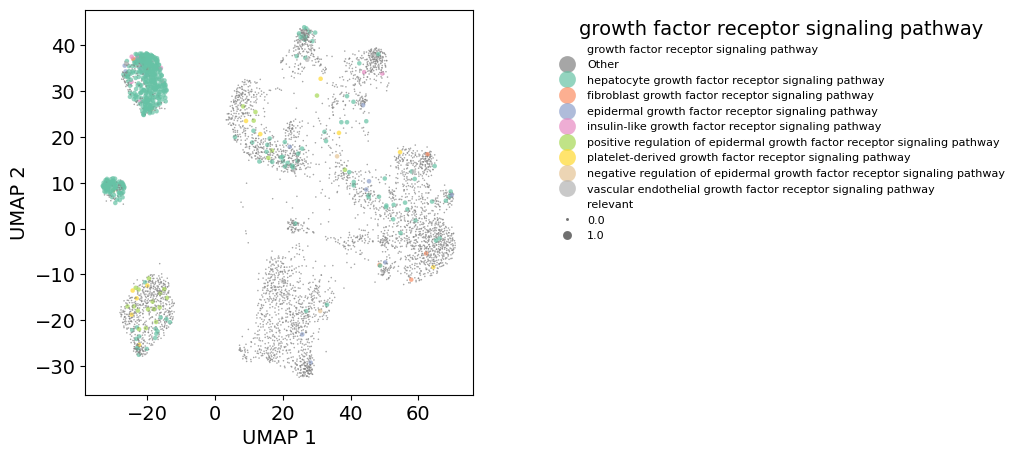

In [44]:
term_snippet = 'growth factor receptor signaling pathway'
test_go_terms = np.asarray([1 if term_snippet in x else 0 for x in mtrx_go_names]).astype(bool)
unique_test_go_terms = [x for x in mtrx_go_names if term_snippet in x]
print(f"Found {sum(test_go_terms)} GO terms with '{term_snippet}' in their name")
print(f"Unique GO terms: {unique_test_go_terms}")
test_counts = go_feature_matrix[test_go_terms,:].clone().sum(dim=0).int()
# get the index of the max count
max_index = go_feature_matrix[test_go_terms,:].clone().argmax(dim=0)
test_counts = (test_counts > 0).float()
df_temp = df_umap.copy()
#df_temp[term_snippet] = test_counts.numpy()
df_temp[term_snippet] = [unique_test_go_terms[x] if test_counts[i] == 1 else 'Other' for i, x in enumerate(max_index.numpy())]
df_temp[term_snippet] = pd.Categorical(df_temp[term_snippet], categories=['Other'] + [x for x in unique_test_go_terms if x != 'Other'], ordered=True)
# create a legend where the first color is grey and the rest is default
temp_palette = [(0.5, 0.5, 0.5)] + sns.color_palette('Set2') + sns.color_palette('Set1')
temp_palette = temp_palette[:len(df_temp[term_snippet].unique())]
df_temp['relevant'] = test_counts.numpy()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(data=df_temp, x='UMAP 1', y='UMAP 2', hue=term_snippet, size='relevant', alpha=0.7, ec=None, ax=ax, palette=temp_palette, sizes=(10, 1))
# move legend to the side
ax.legend(title=term_snippet, loc='upper right', bbox_to_anchor=(2.4, 1), frameon=False, markerscale=2, fontsize=8)
plt.show()

Found 1 GO terms with 'natural killer cell activation' in their name
Unique GO terms: ['natural killer cell activation']


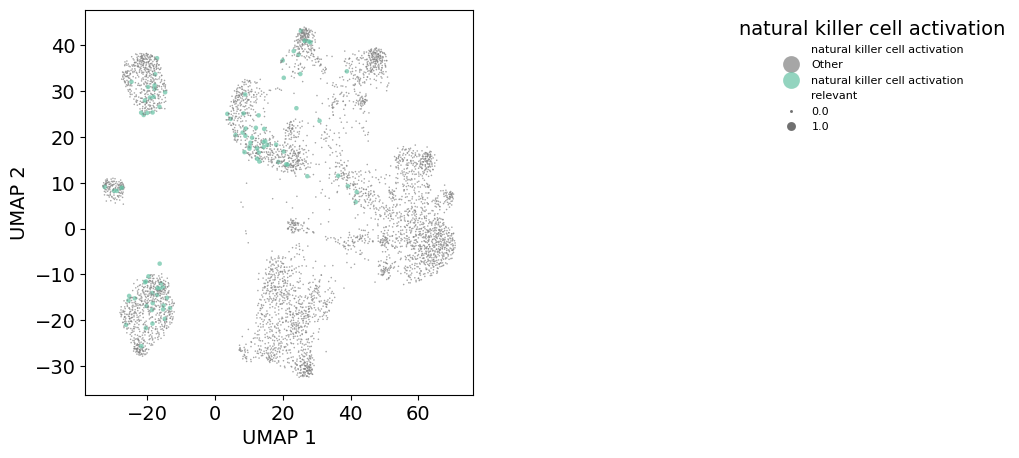

In [45]:
term_snippet = 'natural killer cell activation'
test_go_terms = np.asarray([1 if term_snippet in x else 0 for x in mtrx_go_names]).astype(bool)
unique_test_go_terms = [x for x in mtrx_go_names if term_snippet in x]
print(f"Found {sum(test_go_terms)} GO terms with '{term_snippet}' in their name")
print(f"Unique GO terms: {unique_test_go_terms}")
test_counts = go_feature_matrix[test_go_terms,:].clone().sum(dim=0).int()
# get the index of the max count
max_index = go_feature_matrix[test_go_terms,:].clone().argmax(dim=0)
test_counts = (test_counts > 0).float()
df_temp = df_umap.copy()
#df_temp[term_snippet] = test_counts.numpy()
df_temp[term_snippet] = [unique_test_go_terms[x] if test_counts[i] == 1 else 'Other' for i, x in enumerate(max_index.numpy())]
df_temp[term_snippet] = pd.Categorical(df_temp[term_snippet], categories=['Other'] + [x for x in unique_test_go_terms if x != 'Other'], ordered=True)
# create a legend where the first color is grey and the rest is default
temp_palette = [(0.5, 0.5, 0.5)] + sns.color_palette('Set2') + sns.color_palette('Set1')
temp_palette = temp_palette[:len(df_temp[term_snippet].unique())]
df_temp['relevant'] = test_counts.numpy()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(data=df_temp, x='UMAP 1', y='UMAP 2', hue=term_snippet, size='relevant', alpha=0.7, ec=None, ax=ax, palette=temp_palette, sizes=(10, 1))
# move legend to the side
ax.legend(title=term_snippet, loc='upper right', bbox_to_anchor=(2.4, 1), frameon=False, markerscale=2, fontsize=8)
plt.show()

Found 16 GO terms with 'viral' in their name
Unique GO terms: ['positive regulation of viral genome replication', 'negative regulation of viral genome replication', 'IRES-dependent viral translational initiation', 'viral protein processing', 'positive regulation by host of viral transcription', 'negative regulation of viral transcription', 'positive regulation by host of viral genome replication', 'negative regulation of viral entry into host cell', 'viral budding via host ESCRT complex', 'viral budding from plasma membrane', 'antiviral innate immune response', 'negative regulation by host of viral transcription', 'viral release from host cell', 'suppression of viral release by host', 'positive regulation by host of viral process', 'positive regulation of viral entry into host cell']


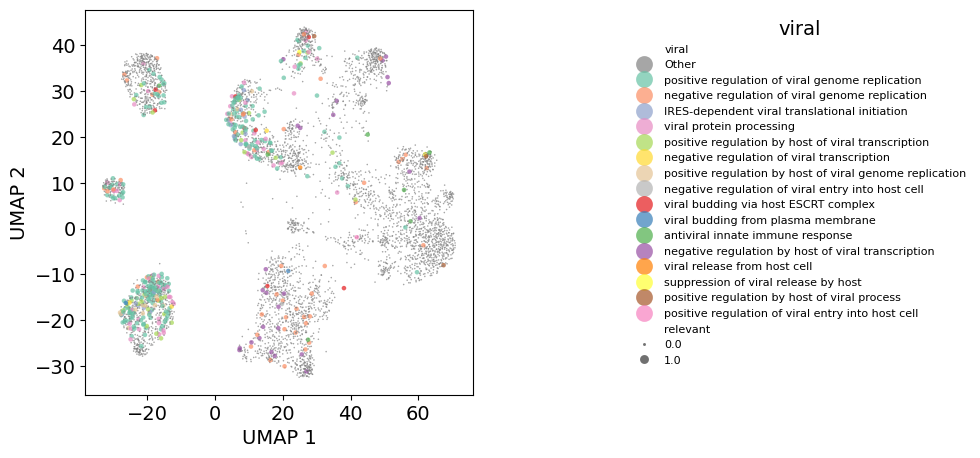

In [46]:
term_snippet = 'viral'

test_go_terms = np.asarray([1 if term_snippet in x else 0 for x in mtrx_go_names]).astype(bool)
unique_test_go_terms = [x for x in mtrx_go_names if term_snippet in x]
print(f"Found {sum(test_go_terms)} GO terms with '{term_snippet}' in their name")
print(f"Unique GO terms: {unique_test_go_terms}")
test_counts = go_feature_matrix[test_go_terms,:].clone().sum(dim=0).int()
# get the index of the max count
max_index = go_feature_matrix[test_go_terms,:].clone().argmax(dim=0)
test_counts = (test_counts > 0).float()
df_temp = df_umap.copy()
#df_temp[term_snippet] = test_counts.numpy()
df_temp[term_snippet] = [unique_test_go_terms[x] if test_counts[i] == 1 else 'Other' for i, x in enumerate(max_index.numpy())]
df_temp[term_snippet] = pd.Categorical(df_temp[term_snippet], categories=['Other'] + [x for x in unique_test_go_terms if x != 'Other'], ordered=True)
# create a legend where the first color is grey and the rest is default
# get a large palette to start with (Set1 + Set2)
temp_palette = [(0.5, 0.5, 0.5)] + sns.color_palette('Set2') + sns.color_palette('Set1')
temp_palette = temp_palette[:len(df_temp[term_snippet].unique())]
df_temp['relevant'] = test_counts.numpy()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(data=df_temp, x='UMAP 1', y='UMAP 2', hue=term_snippet, size='relevant', alpha=0.7, ec=None, ax=ax, palette=temp_palette, sizes=(10, 1))
# move legend to the side
ax.legend(title=term_snippet, loc='upper right', bbox_to_anchor=(2.3, 1), frameon=False, markerscale=2, fontsize=8)
plt.show()

Found 5 GO terms with 'starvation' in their name
Unique GO terms: ['cellular response to starvation', 'cellular response to amino acid starvation', 'cellular response to glucose starvation', 'response to starvation', 'cellular response to leucine starvation']


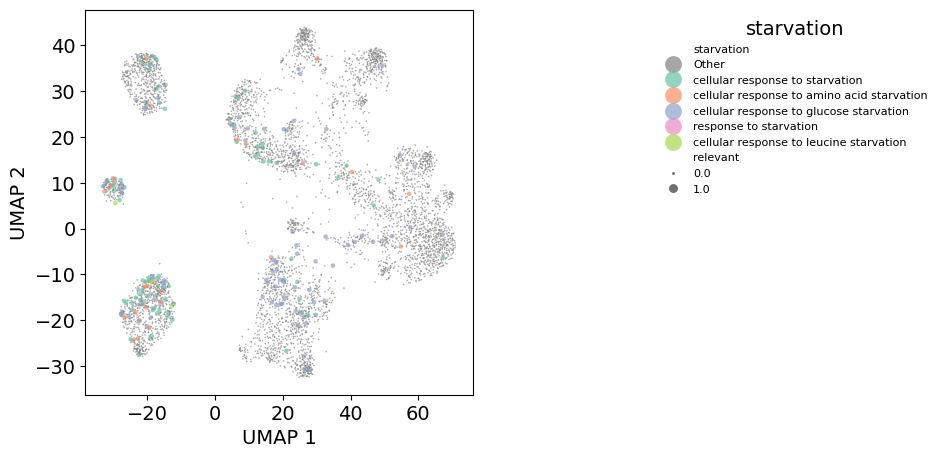

In [47]:
term_snippet = 'starvation'

test_go_terms = np.asarray([1 if term_snippet in x else 0 for x in mtrx_go_names]).astype(bool)
unique_test_go_terms = [x for x in mtrx_go_names if term_snippet in x]
print(f"Found {sum(test_go_terms)} GO terms with '{term_snippet}' in their name")
print(f"Unique GO terms: {unique_test_go_terms}")
test_counts = go_feature_matrix[test_go_terms,:].clone().sum(dim=0).int()
# get the index of the max count
max_index = go_feature_matrix[test_go_terms,:].clone().argmax(dim=0)
test_counts = (test_counts > 0).float()
df_temp = df_umap.copy()
#df_temp[term_snippet] = test_counts.numpy()
df_temp[term_snippet] = [unique_test_go_terms[x] if test_counts[i] == 1 else 'Other' for i, x in enumerate(max_index.numpy())]
df_temp[term_snippet] = pd.Categorical(df_temp[term_snippet], categories=['Other'] + [x for x in unique_test_go_terms if x != 'Other'], ordered=True)
# create a legend where the first color is grey and the rest is default
# get a large palette to start with (Set1 + Set2)
temp_palette = [(0.5, 0.5, 0.5)] + sns.color_palette('Set2') + sns.color_palette('Set1')
temp_palette = temp_palette[:len(df_temp[term_snippet].unique())]
df_temp['relevant'] = test_counts.numpy()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(data=df_temp, x='UMAP 1', y='UMAP 2', hue=term_snippet, size='relevant', alpha=0.7, ec=None, ax=ax, palette=temp_palette, sizes=(10, 1))
# move legend to the side
ax.legend(title=term_snippet, loc='upper right', bbox_to_anchor=(2.2, 1), frameon=False, markerscale=2, fontsize=8)
plt.show()

Found 7 GO terms with 'polarity' in their name
Unique GO terms: ['regulation of establishment of cell polarity', 'establishment of cell polarity', 'establishment of planar polarity', 'Wnt signaling pathway, planar cell polarity pathway', 'establishment or maintenance of epithelial cell apical/basal polarity', 'establishment or maintenance of cell polarity', 'establishment of epithelial cell polarity']


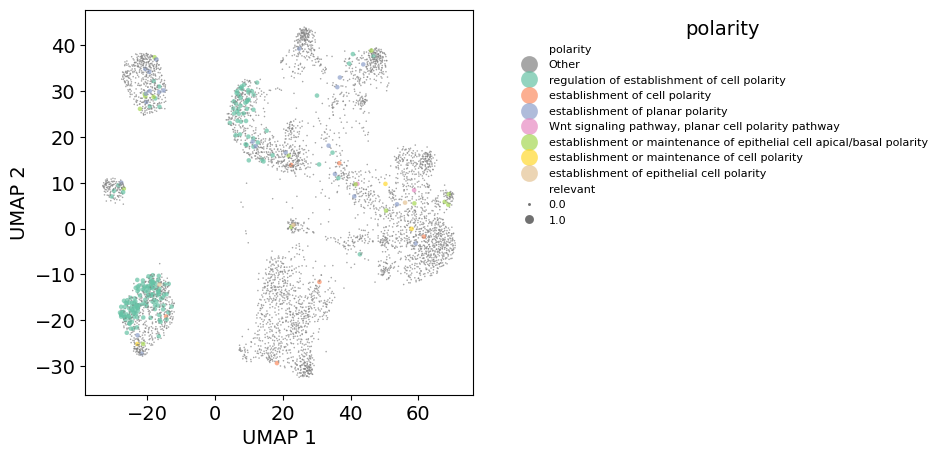

In [48]:
term_snippet = 'polarity'

test_go_terms = np.asarray([1 if term_snippet in x else 0 for x in mtrx_go_names]).astype(bool)
unique_test_go_terms = [x for x in mtrx_go_names if term_snippet in x]
print(f"Found {sum(test_go_terms)} GO terms with '{term_snippet}' in their name")
print(f"Unique GO terms: {unique_test_go_terms}")
test_counts = go_feature_matrix[test_go_terms,:].clone().sum(dim=0).int()
# get the index of the max count
max_index = go_feature_matrix[test_go_terms,:].clone().argmax(dim=0)
test_counts = (test_counts > 0).float()
df_temp = df_umap.copy()
#df_temp[term_snippet] = test_counts.numpy()
df_temp[term_snippet] = [unique_test_go_terms[x] if test_counts[i] == 1 else 'Other' for i, x in enumerate(max_index.numpy())]
df_temp[term_snippet] = pd.Categorical(df_temp[term_snippet], categories=['Other'] + [x for x in unique_test_go_terms if x != 'Other'], ordered=True)
# create a legend where the first color is grey and the rest is default
# get a large palette to start with (Set1 + Set2)
temp_palette = [(0.5, 0.5, 0.5)] + sns.color_palette('Set2') + sns.color_palette('Set1')
temp_palette = temp_palette[:len(df_temp[term_snippet].unique())]
df_temp['relevant'] = test_counts.numpy()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(data=df_temp, x='UMAP 1', y='UMAP 2', hue=term_snippet, size='relevant', alpha=0.7, ec=None, ax=ax, palette=temp_palette, sizes=(10, 1))
# move legend to the side
ax.legend(title=term_snippet, loc='upper right', bbox_to_anchor=(2.2, 1), frameon=False, markerscale=2, fontsize=8)
plt.show()

Found 14 GO terms with 'DNA damage' in their name
Unique GO terms: ['DNA damage response', 'intrinsic apoptotic signaling pathway in response to DNA damage', 'DNA damage checkpoint signaling', 'regulation of DNA damage checkpoint', 'intrinsic apoptotic signaling pathway in response to DNA damage by p53 class mediator', 'mitotic G2 DNA damage checkpoint signaling', 'negative regulation of DNA damage response, signal transduction by p53 class mediator', 'signal transduction in response to DNA damage', 'DNA damage response, signal transduction by p53 class mediator resulting in cell cycle arrest', 'mitotic G1 DNA damage checkpoint signaling', 'DNA damage response, signal transduction by p53 class mediator', 'positive regulation of telomere maintenance in response to DNA damage', 'negative regulation of intrinsic apoptotic signaling pathway in response to DNA damage by p53 class mediator', 'ATP-dependent DNA damage sensor activity']


/tmp/ipykernel_2227424/191345201.py:22: UserWarning: 
The palette list has fewer values (10) than needed (15) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data=df_temp, x='UMAP 1', y='UMAP 2', hue=term_snippet, size='relevant', alpha=0.7, ec=None, ax=ax, palette=temp_palette, sizes=(10, 1))


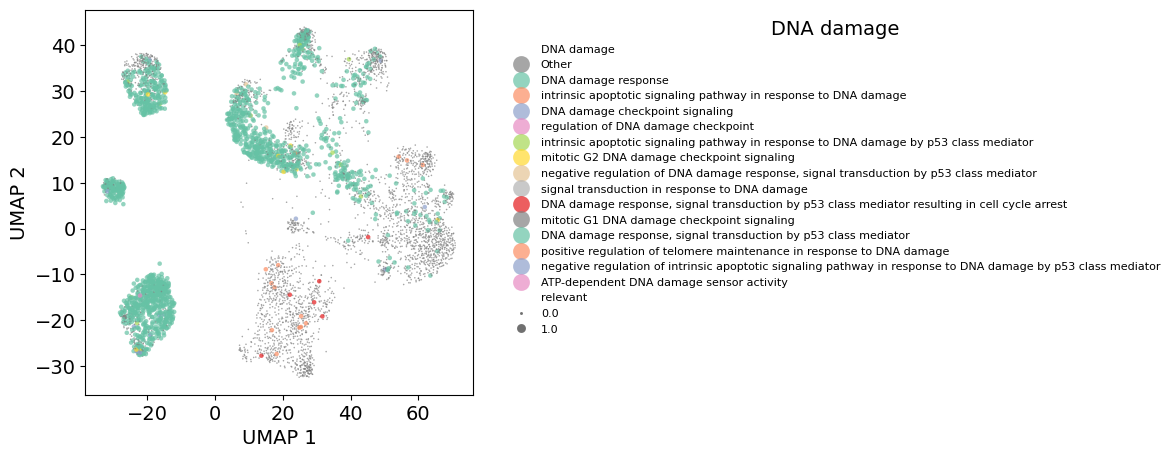

In [50]:
term_snippet = 'DNA damage'

test_go_terms = np.asarray([1 if term_snippet in x else 0 for x in mtrx_go_names]).astype(bool)
unique_test_go_terms = [x for x in mtrx_go_names if term_snippet in x]
print(f"Found {sum(test_go_terms)} GO terms with '{term_snippet}' in their name")
print(f"Unique GO terms: {unique_test_go_terms}")
test_counts = go_feature_matrix[test_go_terms,:].clone().sum(dim=0).int()
# get the index of the max count
max_index = go_feature_matrix[test_go_terms,:].clone().argmax(dim=0)
test_counts = (test_counts > 0).float()
df_temp = df_umap.copy()
#df_temp[term_snippet] = test_counts.numpy()
df_temp[term_snippet] = [unique_test_go_terms[x] if test_counts[i] == 1 else 'Other' for i, x in enumerate(max_index.numpy())]
df_temp[term_snippet] = pd.Categorical(df_temp[term_snippet], categories=['Other'] + [x for x in unique_test_go_terms if x != 'Other'], ordered=True)
# create a legend where the first color is grey and the rest is default
# get a large palette to start with (Set1 + Set2)
temp_palette = [(0.5, 0.5, 0.5)] + sns.color_palette('Set2') + sns.color_palette('Set1')
temp_palette = temp_palette[:len(df_temp[term_snippet].unique())]
df_temp['relevant'] = test_counts.numpy()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(data=df_temp, x='UMAP 1', y='UMAP 2', hue=term_snippet, size='relevant', alpha=0.7, ec=None, ax=ax, palette=temp_palette, sizes=(10, 1))
# move legend to the side
ax.legend(title=term_snippet, loc='upper right', bbox_to_anchor=(2.8, 1), frameon=False, markerscale=2, fontsize=8)
plt.show()

Found 15 GO terms with 'stem cell' in their name
Unique GO terms: ['positive regulation of stem cell population maintenance', 'regulation of stem cell differentiation', 'neuronal stem cell population maintenance', 'somatic stem cell population maintenance', 'regulation of stem cell population maintenance', 'stem cell differentiation', 'stem cell population maintenance', 'negative regulation of stem cell differentiation', 'hematopoietic stem cell differentiation', 'negative regulation of stem cell population maintenance', 'regulation of hematopoietic stem cell differentiation', 'hematopoietic stem cell proliferation', 'stem cell proliferation', 'positive regulation of stem cell proliferation', 'stem cell factor receptor activity']


/tmp/ipykernel_2227424/2535608895.py:22: UserWarning: 
The palette list has fewer values (15) than needed (16) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data=df_temp, x='UMAP 1', y='UMAP 2', hue=term_snippet, size='relevant', alpha=0.7, ec=None, ax=ax, palette=temp_palette, sizes=(10, 1))


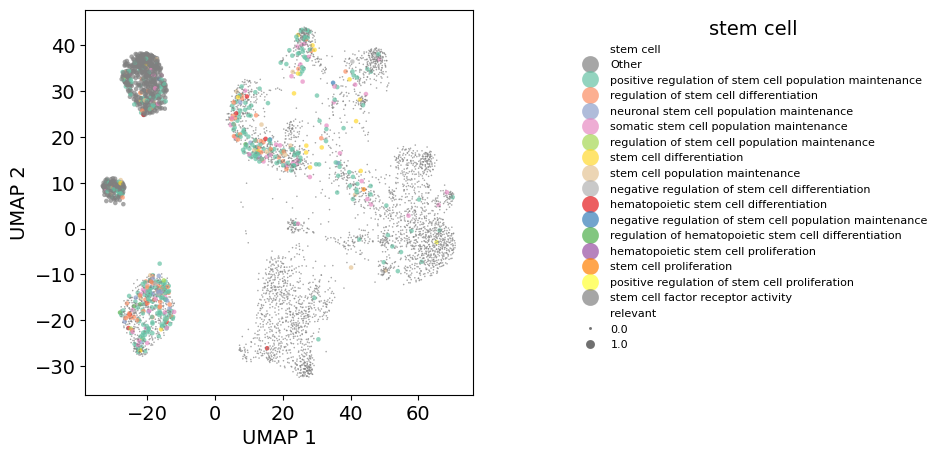

In [51]:
term_snippet = 'stem cell'

test_go_terms = np.asarray([1 if term_snippet in x else 0 for x in mtrx_go_names]).astype(bool)
unique_test_go_terms = [x for x in mtrx_go_names if term_snippet in x]
print(f"Found {sum(test_go_terms)} GO terms with '{term_snippet}' in their name")
print(f"Unique GO terms: {unique_test_go_terms}")
test_counts = go_feature_matrix[test_go_terms,:].clone().sum(dim=0).int()
# get the index of the max count
max_index = go_feature_matrix[test_go_terms,:].clone().argmax(dim=0)
test_counts = (test_counts > 0).float()
df_temp = df_umap.copy()
#df_temp[term_snippet] = test_counts.numpy()
df_temp[term_snippet] = [unique_test_go_terms[x] if test_counts[i] == 1 else 'Other' for i, x in enumerate(max_index.numpy())]
df_temp[term_snippet] = pd.Categorical(df_temp[term_snippet], categories=['Other'] + [x for x in unique_test_go_terms if x != 'Other'], ordered=True)
# create a legend where the first color is grey and the rest is default
# get a large palette to start with (Set1 + Set2)
temp_palette = [(0.5, 0.5, 0.5)] + sns.color_palette('Set2') + sns.color_palette('Set1')
temp_palette = temp_palette[:len(df_temp[term_snippet].unique())]
df_temp['relevant'] = test_counts.numpy()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(data=df_temp, x='UMAP 1', y='UMAP 2', hue=term_snippet, size='relevant', alpha=0.7, ec=None, ax=ax, palette=temp_palette, sizes=(10, 1))
# move legend to the side
ax.legend(title=term_snippet, loc='upper right', bbox_to_anchor=(2.2, 1), frameon=False, markerscale=2, fontsize=8)
plt.show()

Found 12 GO terms with 'maturation' in their name
Unique GO terms: ['protein maturation', 'maturation of 5.8S rRNA', 'autophagosome maturation', 'maturation of SSU-rRNA from tricistronic rRNA transcript (SSU-rRNA, 5.8S rRNA, LSU-rRNA)', 'maturation of SSU-rRNA', 'cell maturation', 'oocyte maturation', 'erythrocyte maturation', 'regulation of synapse maturation', 'neuron maturation', 'phagosome maturation', 'maturation of LSU-rRNA from tricistronic rRNA transcript (SSU-rRNA, 5.8S rRNA, LSU-rRNA)']


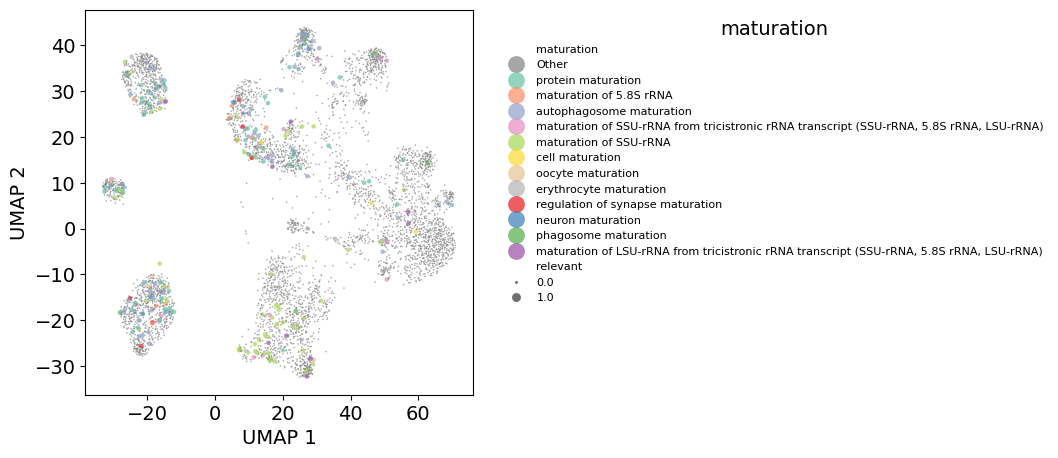

In [52]:
term_snippet = 'maturation'

test_go_terms = np.asarray([1 if term_snippet in x else 0 for x in mtrx_go_names]).astype(bool)
unique_test_go_terms = [x for x in mtrx_go_names if term_snippet in x]
print(f"Found {sum(test_go_terms)} GO terms with '{term_snippet}' in their name")
print(f"Unique GO terms: {unique_test_go_terms}")
test_counts = go_feature_matrix[test_go_terms,:].clone().sum(dim=0).int()
# get the index of the max count
max_index = go_feature_matrix[test_go_terms,:].clone().argmax(dim=0)
test_counts = (test_counts > 0).float()
df_temp = df_umap.copy()
#df_temp[term_snippet] = test_counts.numpy()
df_temp[term_snippet] = [unique_test_go_terms[x] if test_counts[i] == 1 else 'Other' for i, x in enumerate(max_index.numpy())]
df_temp[term_snippet] = pd.Categorical(df_temp[term_snippet], categories=['Other'] + [x for x in unique_test_go_terms if x != 'Other'], ordered=True)
# create a legend where the first color is grey and the rest is default
# get a large palette to start with (Set1 + Set2)
temp_palette = [(0.5, 0.5, 0.5)] + sns.color_palette('Set2') + sns.color_palette('Set1')
temp_palette = temp_palette[:len(df_temp[term_snippet].unique())]
df_temp['relevant'] = test_counts.numpy()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(data=df_temp, x='UMAP 1', y='UMAP 2', hue=term_snippet, size='relevant', alpha=0.7, ec=None, ax=ax, palette=temp_palette, sizes=(10, 1))
# move legend to the side
ax.legend(title=term_snippet, loc='upper right', bbox_to_anchor=(2.5, 1), frameon=False, markerscale=2, fontsize=8)
plt.show()

Found 7 GO terms with 'telomere' in their name
Unique GO terms: ['positive regulation of telomere maintenance via telomerase', 'telomere maintenance', 'positive regulation of telomere maintenance', 'regulation of telomere maintenance', 'telomere maintenance via telomerase', 'negative regulation of telomere maintenance via telomerase', 'positive regulation of telomere maintenance in response to DNA damage']


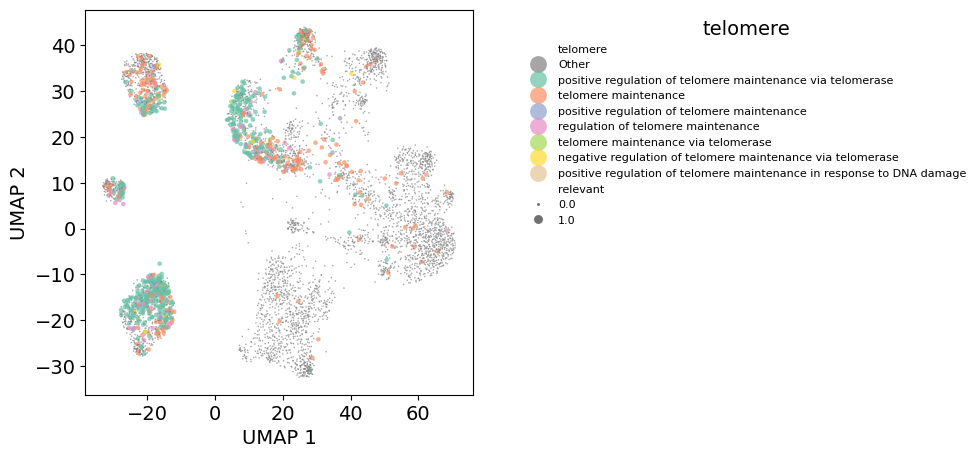

In [53]:
term_snippet = 'telomere'

test_go_terms = np.asarray([1 if term_snippet in x else 0 for x in mtrx_go_names]).astype(bool)
unique_test_go_terms = [x for x in mtrx_go_names if term_snippet in x]
print(f"Found {sum(test_go_terms)} GO terms with '{term_snippet}' in their name")
print(f"Unique GO terms: {unique_test_go_terms}")
test_counts = go_feature_matrix[test_go_terms,:].clone().sum(dim=0).int()
# get the index of the max count
max_index = go_feature_matrix[test_go_terms,:].clone().argmax(dim=0)
test_counts = (test_counts > 0).float()
df_temp = df_umap.copy()
#df_temp[term_snippet] = test_counts.numpy()
df_temp[term_snippet] = [unique_test_go_terms[x] if test_counts[i] == 1 else 'Other' for i, x in enumerate(max_index.numpy())]
df_temp[term_snippet] = pd.Categorical(df_temp[term_snippet], categories=['Other'] + [x for x in unique_test_go_terms if x != 'Other'], ordered=True)
# create a legend where the first color is grey and the rest is default
# get a large palette to start with (Set1 + Set2)
temp_palette = [(0.5, 0.5, 0.5)] + sns.color_palette('Set2') + sns.color_palette('Set1')
temp_palette = temp_palette[:len(df_temp[term_snippet].unique())]
df_temp['relevant'] = test_counts.numpy()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(data=df_temp, x='UMAP 1', y='UMAP 2', hue=term_snippet, size='relevant', alpha=0.7, ec=None, ax=ax, palette=temp_palette, sizes=(10, 1))
# move legend to the side
ax.legend(title=term_snippet, loc='upper right', bbox_to_anchor=(2.3, 1), frameon=False, markerscale=2, fontsize=8)
plt.show()

Found 10 GO terms with 'autophagy' in their name
Unique GO terms: ['autophagy', 'negative regulation of autophagy', 'macroautophagy', 'regulation of macroautophagy', 'positive regulation of autophagy', 'autophagy of mitochondrion', 'piecemeal microautophagy of the nucleus', 'positive regulation of macroautophagy', 'regulation of autophagy', 'negative regulation of macroautophagy']


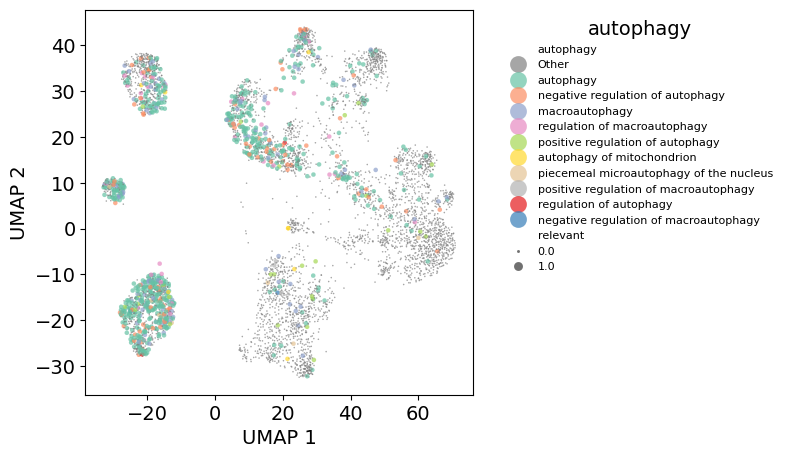

In [54]:
term_snippet = 'autophagy'

test_go_terms = np.asarray([1 if term_snippet in x else 0 for x in mtrx_go_names]).astype(bool)
unique_test_go_terms = [x for x in mtrx_go_names if term_snippet in x]
print(f"Found {sum(test_go_terms)} GO terms with '{term_snippet}' in their name")
print(f"Unique GO terms: {unique_test_go_terms}")
test_counts = go_feature_matrix[test_go_terms,:].clone().sum(dim=0).int()
# get the index of the max count
max_index = go_feature_matrix[test_go_terms,:].clone().argmax(dim=0)
test_counts = (test_counts > 0).float()
df_temp = df_umap.copy()
#df_temp[term_snippet] = test_counts.numpy()
df_temp[term_snippet] = [unique_test_go_terms[x] if test_counts[i] == 1 else 'Other' for i, x in enumerate(max_index.numpy())]
df_temp[term_snippet] = pd.Categorical(df_temp[term_snippet], categories=['Other'] + [x for x in unique_test_go_terms if x != 'Other'], ordered=True)
# create a legend where the first color is grey and the rest is default
# get a large palette to start with (Set1 + Set2)
temp_palette = [(0.5, 0.5, 0.5)] + sns.color_palette('Set2') + sns.color_palette('Set1')
temp_palette = temp_palette[:len(df_temp[term_snippet].unique())]
df_temp['relevant'] = test_counts.numpy()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(data=df_temp, x='UMAP 1', y='UMAP 2', hue=term_snippet, size='relevant', alpha=0.7, ec=None, ax=ax, palette=temp_palette, sizes=(10, 1))
# move legend to the side
ax.legend(title=term_snippet, loc='upper right', bbox_to_anchor=(1.8, 1), frameon=False, markerscale=2, fontsize=8)
plt.show()

Found 6 GO terms with 'death' in their name
Unique GO terms: ['extrinsic apoptotic signaling pathway via death domain receptors', 'negative regulation of extrinsic apoptotic signaling pathway via death domain receptors', 'negative regulation of programmed cell death', 'positive regulation of programmed cell death', 'ectopic germ cell programmed cell death', 'death receptor binding']


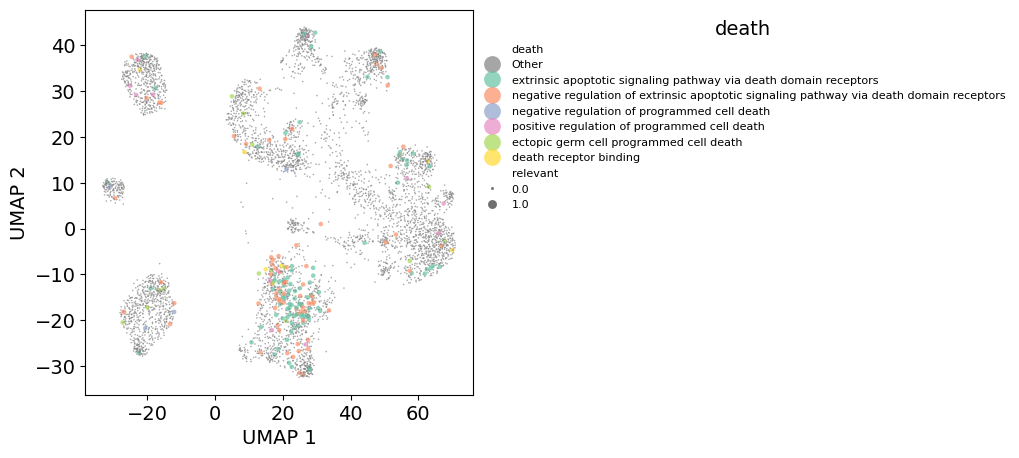

In [55]:
term_snippet = 'death'

test_go_terms = np.asarray([1 if term_snippet in x else 0 for x in mtrx_go_names]).astype(bool)
unique_test_go_terms = [x for x in mtrx_go_names if term_snippet in x]
print(f"Found {sum(test_go_terms)} GO terms with '{term_snippet}' in their name")
print(f"Unique GO terms: {unique_test_go_terms}")
test_counts = go_feature_matrix[test_go_terms,:].clone().sum(dim=0).int()
# get the index of the max count
max_index = go_feature_matrix[test_go_terms,:].clone().argmax(dim=0)
test_counts = (test_counts > 0).float()
df_temp = df_umap.copy()
#df_temp[term_snippet] = test_counts.numpy()
df_temp[term_snippet] = [unique_test_go_terms[x] if test_counts[i] == 1 else 'Other' for i, x in enumerate(max_index.numpy())]
df_temp[term_snippet] = pd.Categorical(df_temp[term_snippet], categories=['Other'] + [x for x in unique_test_go_terms if x != 'Other'], ordered=True)
# create a legend where the first color is grey and the rest is default
# get a large palette to start with (Set1 + Set2)
temp_palette = [(0.5, 0.5, 0.5)] + sns.color_palette('Set2') + sns.color_palette('Set1')
temp_palette = temp_palette[:len(df_temp[term_snippet].unique())]
df_temp['relevant'] = test_counts.numpy()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(data=df_temp, x='UMAP 1', y='UMAP 2', hue=term_snippet, size='relevant', alpha=0.7, ec=None, ax=ax, palette=temp_palette, sizes=(10, 1))
# move legend to the side
ax.legend(title=term_snippet, loc='upper right', bbox_to_anchor=(2.4, 1), frameon=False, markerscale=2, fontsize=8)
plt.show()

Found 6 GO terms with 'tissue' in their name
Unique GO terms: ['adipose tissue development', 'homeostasis of number of cells within a tissue', 'tissue homeostasis', 'skeletal muscle tissue development', 'skeletal muscle tissue regeneration', 'tissue regeneration']


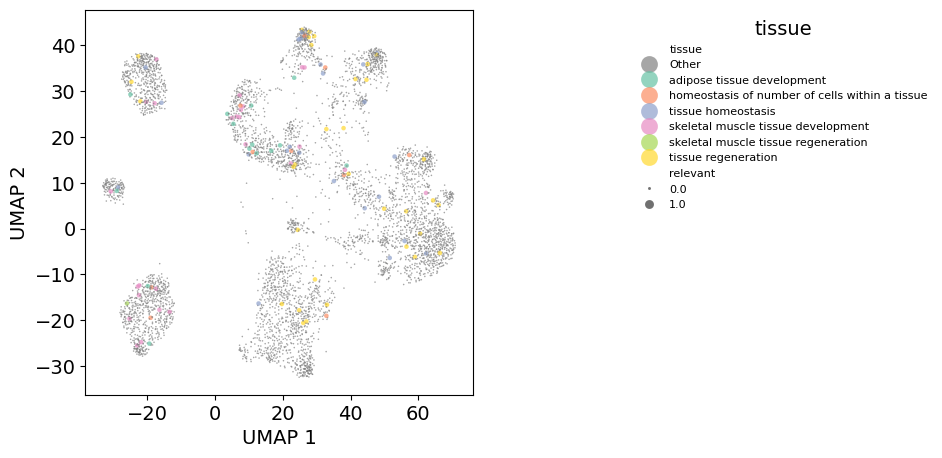

In [56]:
term_snippet = 'tissue'

test_go_terms = np.asarray([1 if term_snippet in x else 0 for x in mtrx_go_names]).astype(bool)
unique_test_go_terms = [x for x in mtrx_go_names if term_snippet in x]
print(f"Found {sum(test_go_terms)} GO terms with '{term_snippet}' in their name")
print(f"Unique GO terms: {unique_test_go_terms}")
test_counts = go_feature_matrix[test_go_terms,:].clone().sum(dim=0).int()
# get the index of the max count
max_index = go_feature_matrix[test_go_terms,:].clone().argmax(dim=0)
test_counts = (test_counts > 0).float()
df_temp = df_umap.copy()
#df_temp[term_snippet] = test_counts.numpy()
df_temp[term_snippet] = [unique_test_go_terms[x] if test_counts[i] == 1 else 'Other' for i, x in enumerate(max_index.numpy())]
df_temp[term_snippet] = pd.Categorical(df_temp[term_snippet], categories=['Other'] + [x for x in unique_test_go_terms if x != 'Other'], ordered=True)
# create a legend where the first color is grey and the rest is default
# get a large palette to start with (Set1 + Set2)
temp_palette = [(0.5, 0.5, 0.5)] + sns.color_palette('Set2') + sns.color_palette('Set1')
temp_palette = temp_palette[:len(df_temp[term_snippet].unique())]
df_temp['relevant'] = test_counts.numpy()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(data=df_temp, x='UMAP 1', y='UMAP 2', hue=term_snippet, size='relevant', alpha=0.7, ec=None, ax=ax, palette=temp_palette, sizes=(10, 1))
# move legend to the side
ax.legend(title=term_snippet, loc='upper right', bbox_to_anchor=(2.2, 1), frameon=False, markerscale=2, fontsize=8)
plt.show()

Found 1 GO terms with 'interleukin-7' in their name
Unique GO terms: ['cellular response to interleukin-7']


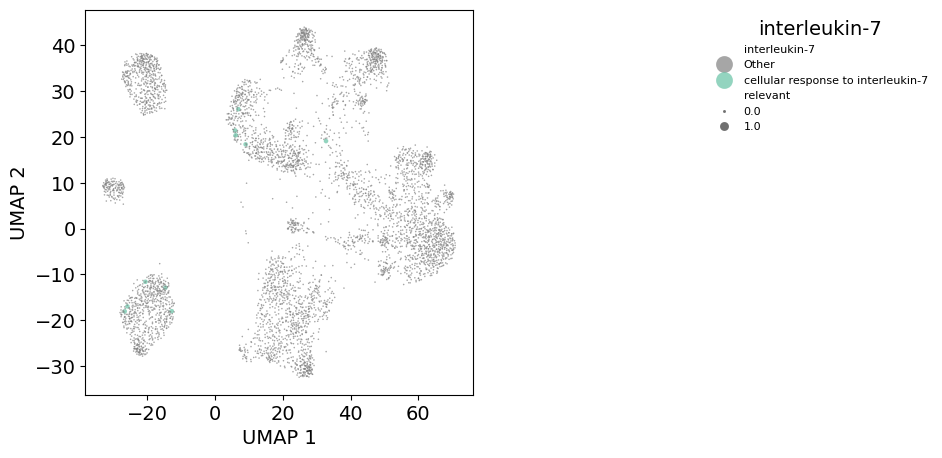

In [57]:
term_snippet = 'interleukin-7'

test_go_terms = np.asarray([1 if term_snippet in x else 0 for x in mtrx_go_names]).astype(bool)
unique_test_go_terms = [x for x in mtrx_go_names if term_snippet in x]
print(f"Found {sum(test_go_terms)} GO terms with '{term_snippet}' in their name")
print(f"Unique GO terms: {unique_test_go_terms}")
test_counts = go_feature_matrix[test_go_terms,:].clone().sum(dim=0).int()
# get the index of the max count
max_index = go_feature_matrix[test_go_terms,:].clone().argmax(dim=0)
test_counts = (test_counts > 0).float()
df_temp = df_umap.copy()
#df_temp[term_snippet] = test_counts.numpy()
df_temp[term_snippet] = [unique_test_go_terms[x] if test_counts[i] == 1 else 'Other' for i, x in enumerate(max_index.numpy())]
df_temp[term_snippet] = pd.Categorical(df_temp[term_snippet], categories=['Other'] + [x for x in unique_test_go_terms if x != 'Other'], ordered=True)
# create a legend where the first color is grey and the rest is default
# get a large palette to start with (Set1 + Set2)
temp_palette = [(0.5, 0.5, 0.5)] + sns.color_palette('Set2') + sns.color_palette('Set1')
temp_palette = temp_palette[:len(df_temp[term_snippet].unique())]
df_temp['relevant'] = test_counts.numpy()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(data=df_temp, x='UMAP 1', y='UMAP 2', hue=term_snippet, size='relevant', alpha=0.7, ec=None, ax=ax, palette=temp_palette, sizes=(10, 1))
# move legend to the side
ax.legend(title=term_snippet, loc='upper right', bbox_to_anchor=(2.2, 1), frameon=False, markerscale=2, fontsize=8)
plt.show()

In [68]:
global_go_feature_matrix = go_feature_matrix[:, [torch.where(mtrx_feature_ids == i)[0] for i in df_umap[df_umap['feature_type'] == 'global']['feature'].values.tolist()]]

global_go_feature_df = pd.DataFrame({
    'name': mtrx_go_names,
    'feature_counts': go_feature_matrix.sum(dim=1).numpy(),
    'global_feature_counts': global_go_feature_matrix.sum(dim=1).numpy()
})
# kick out counts of 0
local_go_feature_df = global_go_feature_df[global_go_feature_df['global_feature_counts'] == 0]
global_go_feature_df = global_go_feature_df[global_go_feature_df['global_feature_counts'] > 0]

In [69]:
# sort by global feature counts
global_go_feature_df = global_go_feature_df.sort_values(by='global_feature_counts', ascending=False)
global_go_feature_df.head(10)

name  feature_counts  \
64                              cytoplasmic translation          2516.0   
45                                          translation          2482.0   
1913                 structural constituent of ribosome          2451.0   
1889                                  chromatin binding          2254.0   
1901                                       mRNA binding          1832.0   
24                       mRNA splicing, via spliceosome          1833.0   
3                                          RNA splicing          1765.0   
5     negative regulation of DNA-templated transcrip...          1716.0   
1886                 transcription coactivator activity          1705.0   
1888                   ubiquitin protein ligase binding          1613.0   

      global_feature_counts  
64                   2417.0  
45                   2410.0  
1913                 2376.0  
1889                 2112.0  
1901                 1761.0  
24                   1727.0  
3                    1669.0  
5                    1656.0  
1886                 1626.0  
1888                 1571.0

In [71]:
# sort by global feature counts
global_go_feature_df = global_go_feature_df.sort_values(by='global_feature_counts', ascending=True)
global_go_feature_df[global_go_feature_df['global_feature_counts'] >= 100].head(10)

name  feature_counts  \
1656   negative regulation of interleukin-17 production           106.0   
555                 positive regulation of angiogenesis           102.0   
139     RNA splicing, via transesterification reactions           104.0   
273                        multivesicular body assembly           101.0   
168               phosphatidylcholine catabolic process           108.0   
629             cellular response to glucose starvation           103.0   
550   homophilic cell adhesion via plasma membrane a...           103.0   
270                            mitotic spindle assembly           112.0   
278                mitotic sister chromatid segregation           109.0   
250                epithelial to mesenchymal transition           106.0   

      global_feature_counts  
1656                  100.0  
555                   100.0  
139                   100.0  
273                   100.0  
168                   102.0  
629                   102.0  
550                   102.0  
270                   103.0  
278                   104.0  
250                   104.0

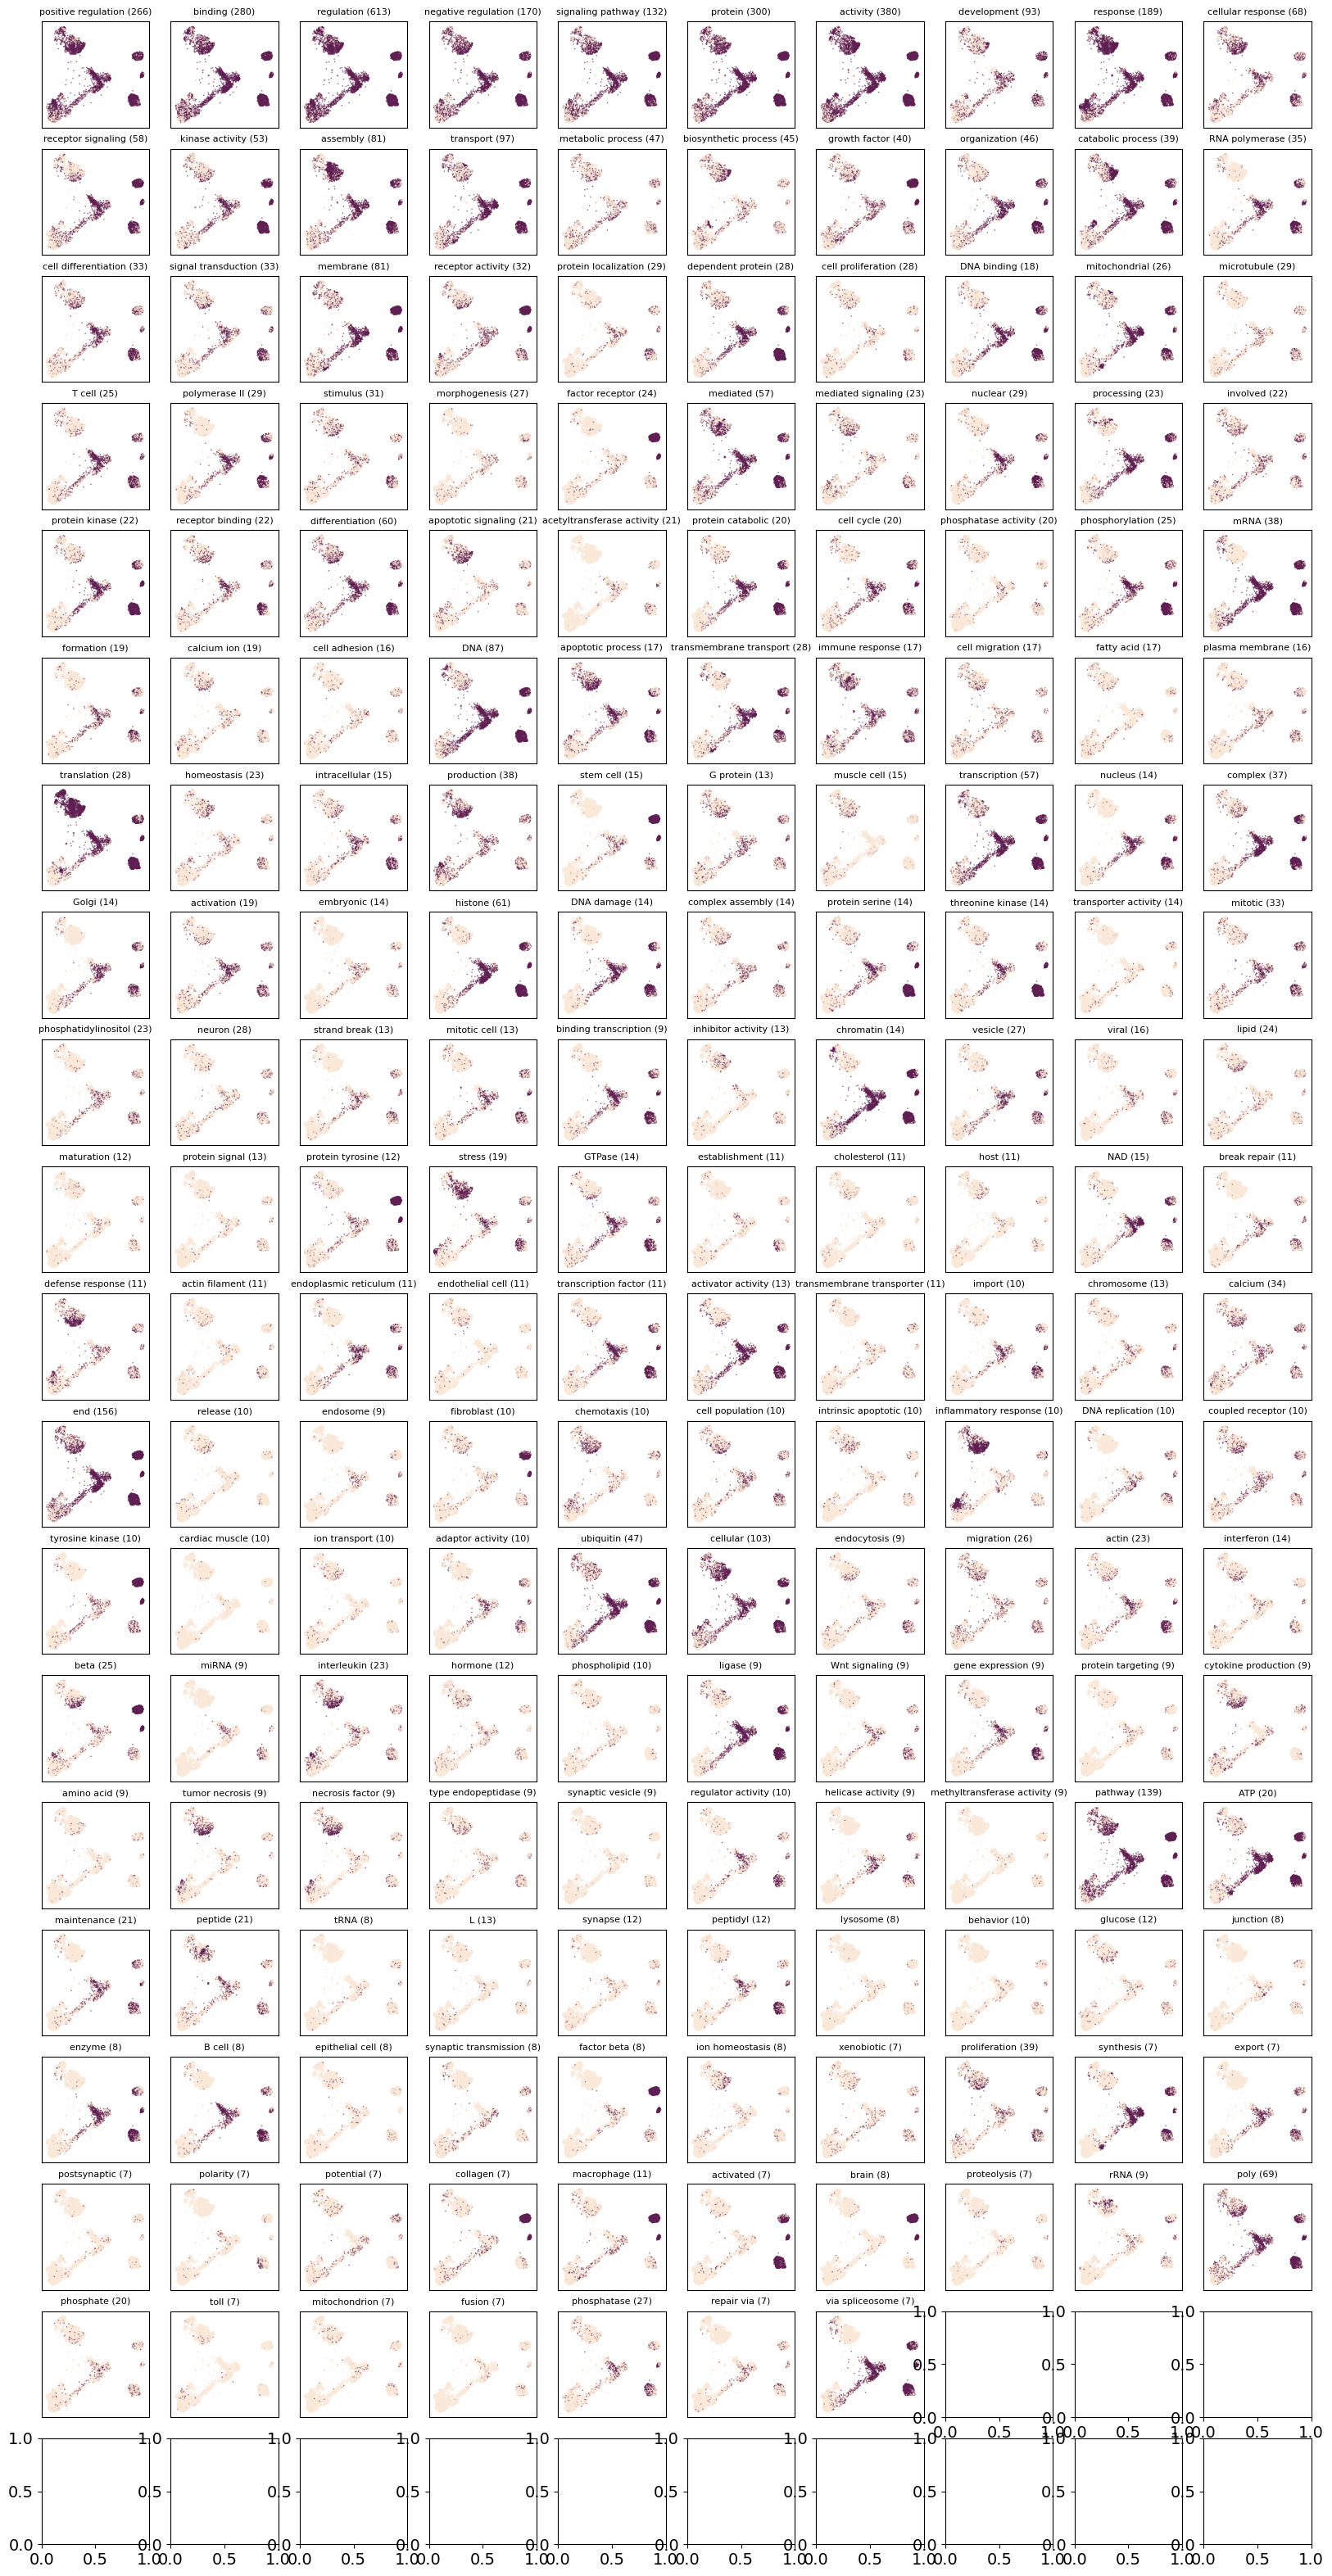

In [72]:
n_cols = 10
n_rows = math.ceil(len(wordcloud.words_.keys()) / n_cols)

binary_colors = sns.color_palette('rocket_r', 100)
binary_colors = [binary_colors[0], binary_colors[75]]

fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*2, n_rows*2))

i = 0
for term_snippet in wordcloud.words_.keys():
    test_go_terms = np.asarray([1 if term_snippet in x else 0 for x in mtrx_go_names]).astype(bool)
    if sum(test_go_terms) == 0:
        continue
    #print([mtrx_go_names[i] for i, x in enumerate(test_go_terms) if x == 1])
    #print(f"Found {sum(test_go_terms)} GO terms with '{term_snippet}' in their name")
    test_counts = go_feature_matrix[test_go_terms,:].clone().sum(dim=0).int()
    #test_counts = go_feature_matrix[:,:].clone().sum(dim=0).int()
    test_counts = (test_counts > 0).float()
    df_temp = df_umap.copy()
    df_temp[term_snippet] = test_counts.numpy()
    sns.scatterplot(data=df_temp, x='UMAP 1', y='UMAP 2', hue=term_snippet, s=1, alpha=0.7, ec=None, ax=ax[i//n_cols, i%n_cols], palette=binary_colors)
    ax[i//n_cols, i%n_cols].set_title(term_snippet + f" ({sum(test_go_terms)})", fontsize=8)
    ax[i//n_cols, i%n_cols].get_legend().remove()
    # remove ticks and labels
    ax[i//n_cols, i%n_cols].set_xticks([])
    ax[i//n_cols, i%n_cols].set_yticks([])
    ax[i//n_cols, i%n_cols].set_xlabel('')
    ax[i//n_cols, i%n_cols].set_ylabel('')
    i += 1
plt.show()

### Get latent space embeddings

In [23]:
enformer_embeddings = pd.read_csv('./03_results/embeddings/human_bonemarrow_geneformer.csv', index_col=0)
celltype_values = enformer_embeddings['cell_type'].values[train_indices]
enformer_embeddings = enformer_embeddings.iloc[train_indices, :-1]

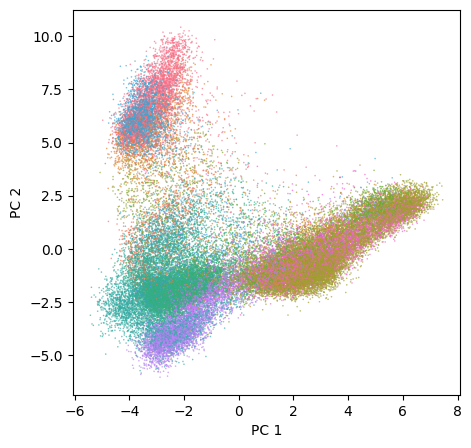

In [28]:
# plot a pca and a umap of the enformer embeddings coloreed by cell type
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(enformer_embeddings)
df_pca = pd.DataFrame(pca_embeddings, columns=['PC 1', 'PC 2'])
df_pca['cell_type'] = celltype_values
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(data=df_pca, x='PC 1', y='PC 2', hue='cell_type', alpha=0.7, ec=None, ax=ax, s=1)
ax.legend(title='Cell Type', loc='upper right', bbox_to_anchor=(1.4, 1), frameon=False, markerscale=5, fontsize=8).remove()
plt.show()

/home/vschuste/miniconda3/envs/sc_mechinterp/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


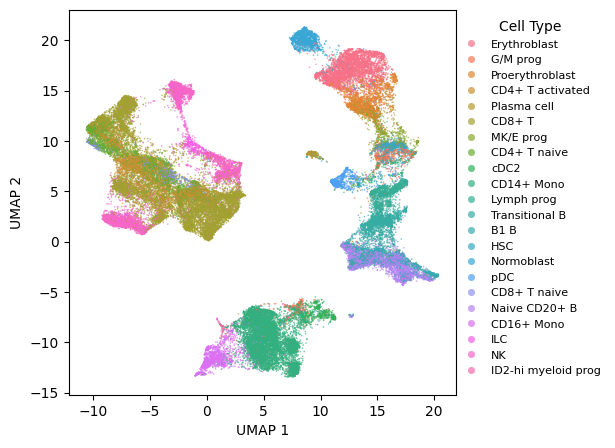

In [29]:
# plot a umap of the same

import umap

reducer = umap.UMAP(n_components=2, min_dist=0.2, n_neighbors=20, random_state=0, spread=2)
embedding = reducer.fit_transform(enformer_embeddings)

df_umap = pd.DataFrame(embedding, columns=['UMAP 1', 'UMAP 2'])
df_umap['cell_type'] = celltype_values
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(data=df_umap, x='UMAP 1', y='UMAP 2', hue='cell_type', alpha=0.7, ec=None, ax=ax, s=1)
ax.legend(title='Cell Type', loc='upper right', bbox_to_anchor=(1.4, 1), frameon=False, markerscale=5, fontsize=8)
plt.show()